<a href="https://colab.research.google.com/github/AtharvAwasthi/AtharvAwasthi/blob/main/Deep_Learning_Framework_to_Optimize_Real_Estate_Valuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Framework to Optimize Real Estate Valuation

> ###### Authored by Atharv Awasthi and Brendan Nguyen




---



### Data Sources: [realtor.com dataset](https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset), [IRS dataset](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi), [Zillow Home Value Index Dataset](https://www.zillow.com/research/data/)

For this project, we analyzed property-level housing data that originally came from realtor.com. It contains over 1 million current (updated as of 12/5) listings, primarily in the northeastern United States. The data set contains information about the number of bedrooms, number of bathrooms, square footage, lot size, price, date of most recent sale, location, and whether the house is for sale or under construction. We used this data for several exploratory and analytical models. First, we tested various regression models to try to explain house price from its attributes, tuning the hyperparameters as we went. Then, we found another data set from the IRS that contains zipcode-level income data, which we used to compare house price with average income bracket for a given region. Lastly, we found a data set from Zillow that contains a time series for its estimated home value index at the zip code level. Since we were interested in the current home value index for our analysis of current listings, we used the most recent home value indices. This data is broken down by number of bedrooms, which enabled us to join more specifically on our original data set. This allowed us to classify each property in our data set as either overpriced, underpriced, or reasonably priced. From there, we trained and tested a variety of classification models, including a neural network, to use the attributes of a given property (number of bedrooms, number of bathrooms, lot size, and square footage) to classify a each property as overpriced or underpriced. Ultimately, we wanted to see what attributes of a house people tend to believe are more valuable than the market suggests.

Since we worked with zipcode level data, we created several visualizations in which the relevant zipcodes were geocoded and plotted on a map of the United States. The code below installs the appropriate packages that allowed us to create these visualizations.

In [ ]:
! pip install pandas-bokeh | grep -v 'already satisfied'
! pip install pgeocode | grep -v 'already satisfied'
! pip install sqlalchemy==1.4.46 | grep -v 'already satisfied'
! pip install pandasql | grep -v 'already satisfied'

The following lines of code import all the necessary packages for our computations, visualizations, data transformations, and modelling.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas_bokeh
import datetime
import pgeocode
import geopandas as gpd
import pandasql as ps #SQL on Pandas Dataframe
from shapely.geometry import Point
from geopandas import GeoDataFrame
pandas_bokeh.output_notebook() # this line allows the map visualizations to appear within this notebook
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

## Importing and Preprocessing

The code below reads in our main data set as a Pandas data frame.

In [ ]:
properties = pd.read_csv("realtor_data.zip.csv")
properties

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0
...,...,...,...,...,...,...,...,...,...,...
1204061,for_sale,3.0,3.0,0.61,North Greenbush,New York,12198.0,1900.0,NaN,536250.0
1204062,for_sale,3.0,3.0,0.48,North Greenbush,New York,12198.0,2031.0,NaN,550000.0
1204063,for_sale,4.0,3.0,1.00,North Greenbush,New York,12198.0,2480.0,NaN,449900.0
1204064,for_sale,3.0,3.0,4.79,North Greenbush,New York,12198.0,2950.0,NaN,657850.0


Some of the properties in the data set have not been built yet, which means the data for these properties is more volatile and more data is missing for these properties. Accordingly, we restricted our analysis to only those properties that are currently for sale. Additionally, one of the regressors in our models is the date since the last sale. For this, we require that each property has been sold before, so we also restricted our analysis to only those properties that have been sold before. The code below achieves these restrictions and renames the columns to more appropriate names, using PandasSql.

In [ ]:
for_sale_only_query = """
SELECT bed AS num_bedrooms,
       bath AS num_bathrooms,
       acre_lot AS lot_size,
       city,
       state,
       zip_code,
       house_size AS sqft,
       prev_sold_date AS last_sold,
       price
FROM properties
WHERE status == "for_sale" AND prev_sold_date IS NOT NULL
"""
properties = ps.sqldf(for_sale_only_query, locals())
properties

,num_bedrooms,num_bathrooms,lot_size,city,state,zip_code,sqft,last_sold,price
0,3.0,2.0,NaN,Canovanas,Puerto Rico,729.0,1200.0,2020-02-28,76900.0
1,3.0,2.0,NaN,Canovanas,Puerto Rico,729.0,1200.0,2020-02-28,76900.0
2,3.0,2.0,NaN,Canovanas,Puerto Rico,729.0,1200.0,2020-02-28,76900.0
3,7.0,3.0,0.09,Dorado,Puerto Rico,949.0,1192.0,2019-06-28,110000.0
4,3.0,2.0,NaN,Canovanas,Puerto Rico,729.0,1200.0,2020-02-28,76900.0
...,...,...,...,...,...,...,...,...,...
617404,NaN,NaN,2.85,North Greenbush,New York,12198.0,NaN,2008-09-02,110000.0
617405,4.0,3.0,1.85,North Greenbush,New York,12198.0,3082.0,2016-09-07,665000.0
617406,NaN,NaN,2.10,North Greenbush,New York,12198.0,NaN,2017-12-20,75000.0
617407,3.0,3.0,0.60,Wynantskill,New York,12198.0,2457.0,2013-11-25,435000.0


It may appear concerning at first that some rows are exactly the same as one another. However, this is a typical feature of housing development projects, which tend to standardize the features, layouts, and prices, and sell all at once. As a result, it is likely that most of these properties are, indeed, distinct. Accordingly, we chose to label each property with a unique ID, which helped keep track of properties and ensured that we could properly merge data frames during our exploratory data analysis while maintaining a proper "ordering" of properties.

In [ ]:
np.random.seed(42) # we set the seed to 42 for our results to be reproducible
len_of_longest_id = len(str(len(properties) - 1)) # determine how many IDs we need in order to get unique ones
uniform_len_ids = np.arange(len(properties)).astype(str) # create an array of integer IDs as long as the data frame, then convert to string
np.random.shuffle(uniform_len_ids) # ensure that the IDs are randomly assigned to the properties --> no unintended ordering
uniform_len_ids = [id.zfill(len_of_longest_id) for id in uniform_len_ids] # pads the shorter ids with leading zeros to ensure IDs are of the same length
properties.insert(0, "id", uniform_len_ids) # add the ID column
properties

,id,num_bedrooms,num_bathrooms,lot_size,city,state,zip_code,sqft,last_sold,price
0,076634,3.0,2.0,NaN,Canovanas,Puerto Rico,729.0,1200.0,2020-02-28,76900.0
1,188003,3.0,2.0,NaN,Canovanas,Puerto Rico,729.0,1200.0,2020-02-28,76900.0
2,162663,3.0,2.0,NaN,Canovanas,Puerto Rico,729.0,1200.0,2020-02-28,76900.0
3,275063,7.0,3.0,0.09,Dorado,Puerto Rico,949.0,1192.0,2019-06-28,110000.0
4,077100,3.0,2.0,NaN,Canovanas,Puerto Rico,729.0,1200.0,2020-02-28,76900.0
...,...,...,...,...,...,...,...,...,...,...
617404,110268,NaN,NaN,2.85,North Greenbush,New York,12198.0,NaN,2008-09-02,110000.0
617405,259178,4.0,3.0,1.85,North Greenbush,New York,12198.0,3082.0,2016-09-07,665000.0
617406,365838,NaN,NaN,2.10,North Greenbush,New York,12198.0,NaN,2017-12-20,75000.0
617407,131932,3.0,3.0,0.60,Wynantskill,New York,12198.0,2457.0,2013-11-25,435000.0


The date when the property was last sold does not have a particularly useful numerical interpretation. Instead, we are interested in the time since the property was last sold. The following code changes this column to contain the number of days that have elapsed since the property was last sold. That will help us determine whether higher "churn" is associated with higher price, which will inform our model selection.

In [ ]:
curr_date = datetime.datetime.strptime('2023-12-08', "%Y-%m-%d") # date of most recent update to our code
properties["last_sold"] = properties["last_sold"].apply(lambda x: (curr_date - datetime.datetime.strptime(x, "%Y-%m-%d")).days) # find the difference between the current date and the date the property was last sold, in days
properties = properties.rename(columns = {"last_sold" : "days_since_last_sale"}, inplace = False) # change the column name accordingly
properties

,id,num_bedrooms,num_bathrooms,lot_size,city,state,zip_code,sqft,days_since_last_sale,price
0,076634,3.0,2.0,NaN,Canovanas,Puerto Rico,729.0,1200.0,1379,76900.0
1,188003,3.0,2.0,NaN,Canovanas,Puerto Rico,729.0,1200.0,1379,76900.0
2,162663,3.0,2.0,NaN,Canovanas,Puerto Rico,729.0,1200.0,1379,76900.0
3,275063,7.0,3.0,0.09,Dorado,Puerto Rico,949.0,1192.0,1624,110000.0
4,077100,3.0,2.0,NaN,Canovanas,Puerto Rico,729.0,1200.0,1379,76900.0
...,...,...,...,...,...,...,...,...,...,...
617404,110268,NaN,NaN,2.85,North Greenbush,New York,12198.0,NaN,5575,110000.0
617405,259178,4.0,3.0,1.85,North Greenbush,New York,12198.0,3082.0,2648,665000.0
617406,365838,NaN,NaN,2.10,North Greenbush,New York,12198.0,NaN,2179,75000.0
617407,131932,3.0,3.0,0.60,Wynantskill,New York,12198.0,2457.0,3665,435000.0


The following creates a scatterplot that plots price versus days since last sale. Based on this plot, there does not appear to be much of a relationship between the days since last sale and the price. However, we may use this variable later in the analysis.

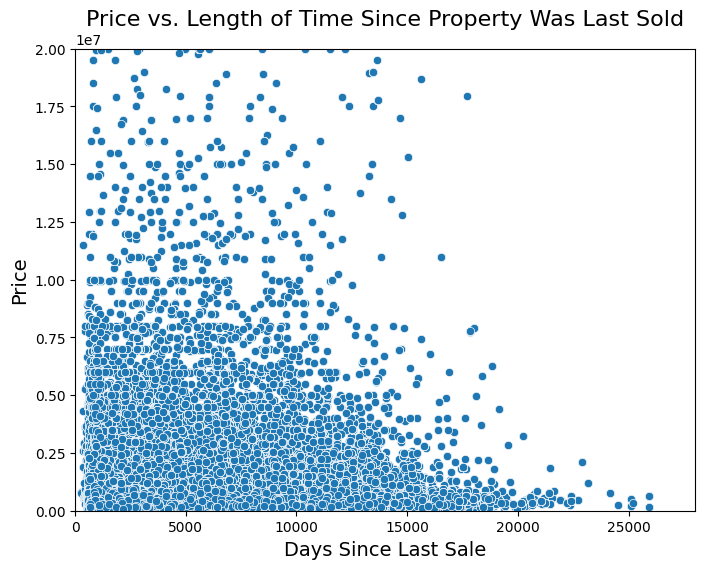

In [ ]:
plt.figure(figsize = (8, 6))
sns.scatterplot(properties, x = "days_since_last_sale", y = "price", palette = "pastel")
plt.xlabel("Days Since Last Sale", fontsize = 14)
plt.ylabel("Price", fontsize = 14)
plt.xlim(0, 28000)
plt.ylim(0, 20000000) # There are a few properties that are more expensive than $20 million, but for the purposes of clarity in this visualization, we cut it off at $20 million
plt.title("Price vs. Length of Time Since Property Was Last Sold", fontsize=16)
plt.show()

## Handling Null Values

The data frame up to this point includes some missing data. In fact, nearly half of the rows of the data frame have at least one null value. Simply dropping the rows with null values could potentially be problematic. Not only would we lose over 300,000 rows of data, but we could be introducing biases in the data by oversampling regions for which data is more likely to be collected (e.g., large cities). Introducing such biases would mean that our models would have less predictive power for a generic property/region.

Instead of simply dropping all rows with null, we imputed values using a more complex form of K-Nearest Neighbors imputation. It's no secret that real estate attributes (especially price) depend heavily on their location. As a result, we used the zip codes as essentially an index upon which null values would be imputated. We followed the following procedure:

**Step 1: Drop any rows for which the zipcode is undefined.** For our dataset up to this point, this is only 13 rows. Considering the size of our data, this will not have any substantial impact on the data.

**Step 2: Replace the cities that have missing values with the mode for their zipcode.** Some zipcodes may be bigger or smaller than a city, so this is inexact, but it provides the closest approximation to the correct city. Additionally, the city is not strictly necessary for any of our models; rather, we used zipcodes for distinguishing locations in our models. The purpose of replacing the cities with the mode is purely for tidiness.

**Step 3: Create a data frame that contains only the numerical columns from the original dataframe and the ids.** KNN imputation only works with numerical data, and we are only interested in filling in the missing numerical values. This includes the following fields: num_bedrooms, num_bathrooms, sqft, lot_size, and days_since_last_sale. In order to keep track of the properties, we also include the id column (though it will not be used for imputation, as it is a random string of numbers and carries no meaningful value).

**Step 4: Compile the zipcodes in which there exist properties with missing data.**

**Step 5: Create a class that performs unscaling.** We want to scale the data before applying KNN imputation. However, after performing KNN imputation, we want the imputed values to be unscaled. That is, we want them to be on the scale of the original data. In order to do this, we define an Unscaler() class that undoes the transformation made by the StandardScaler().

**Step 6: Create a function that does the following:** 1) Takes a zipcode input and creates a data frame of all values in properties_no_city_state_ls that have this zipcode; 2) From this grouping, create a Pipeline that does scaling, K-Nearest-Neighbors imputation, and unscaling all in one step; 3) For every property/ID that was operated on during this grouping, replace the values in properties_no_city_state_ls with the updated, non-null values. Note that the number of neighbors used for imputation increases with the number of properties in that zipcode. Additionally, the imputation will only occur if there are at least 2 other properties with non-null values for a given column.

**Step 7: For every zipcode in the data frame created in Step 4, execute the function defined in Step 6.**

**Step 8: Remove any remaining null rows.** Recall from Step 6 that the KNN imputation that we implemented did not update every row. If there was not enough accompanying data for a given zipcode and for a given field, the value would remain null, as we did not want to bias our choices. As a result, there are a few rows that remain null after the KNN imputation. These are removed in this step.

**Step 9: Join the imputed data frame (properties_no_city_state_ls) with the original data frame (properties).** We join the data frames using the ID as the key. This allows us to recover the categorical variables that we had dropped out prior to doing KNN imputation. Since the columns in properties_no_city_state_ls are a subset of the columns in properties, there will naturally be several duplicate columns in the merged data frame. We choose the updated columns (i.e., the ones on which we performed the imputation).

**Step 10: Round the integer variables to their nearest values.** The num_bedroom and num_bathroom columns should contain integer data (we are not considering the possibility of "half" bathrooms, as it is not truly half of a bathroom). The KNN imputations may have imputed non-integer means for some rows. To account for this, we replaced the imputed values for num_bedrooms and num_bathrooms with their rounded, integer values.

After these steps, we are left with a data frame that has imputed many of the missing values. This processed allowed us to save hundreds of thousands of rows of data.


In [ ]:
# Step 1
drop_null_zips_query = """
SELECT *
FROM properties
WHERE zip_code IS NOT NULL
"""
properties = ps.sqldf(drop_null_zips_query, locals()).reset_index(drop = True)
properties["zip_code"] = properties["zip_code"].apply(lambda x: int(round(x)))

# Step 2
def replace_empty_city_with_mode(x) :
  if x.mode().empty :
    return np.nan
  else :
    return x.fillna(x.mode()[0])
properties["city"] = properties.groupby(["zip_code"])["city"].apply(lambda x: replace_empty_city_with_mode(x)) # replace missing cities with most common city, given zip code
props_query = """
SELECT *
FROM properties
WHERE city IS NOT NULL
"""
properties = ps.sqldf(props_query, locals()).reset_index(drop = True)

# Step 3
pncsl_query = """
SELECT id,
       num_bedrooms,
       num_bathrooms,
       lot_size,
       zip_code,
       sqft,
       price,
       days_since_last_sale
FROM properties
"""
properties_no_city_state_ls = ps.sqldf(pncsl_query, locals()).reset_index(drop = True)

# Step 4
tuples_with_missing_data = properties_no_city_state_ls[properties_no_city_state_ls.isnull().any(axis = 1)] # all rows with missing data
zip_codes_with_rows_with_missing_data = list(tuples_with_missing_data["zip_code"].unique()) # all zip codes for which there exist properties that are in the dataframe created above

# Step 5
class Unscaler(BaseEstimator, TransformerMixin) :
  def __init__(self, scale_fun) :
    self.scale = scale_fun

  def fit(self, x, y = None) :
    return self

  def transform(self, x) :
    return self.scale.inverse_transform(x)

# Step 6
def knn_imputer_from_zip_group(zc) :
  global properties_no_city_state_ls # refer to the globally defined data frame
  same_zip_df = properties_no_city_state_ls[properties_no_city_state_ls["zip_code"] == zc] # create a data frame of properties with zipcode zc
  columns_to_impute = ["num_bedrooms", "num_bathrooms", "lot_size", "zip_code", "sqft", "price", "days_since_last_sale"] # the features we want to use for imputation
  ids = ["id"] # the id is important to keep, but it is not part of the imputation
  same_zip_impute = same_zip_df[columns_to_impute]
  same_zip_keep = same_zip_df[ids]

  ids_to_update = same_zip_keep["id"]
  if len(same_zip_df) > 1 and all(same_zip_impute[col].notna().sum() >= 2 for col in same_zip_impute.columns) : # only impute if there are other properties that share the zip code and if those have sufficient non-null data
      scaler = StandardScaler()
      pipeline = Pipeline([
          ("scaler", scaler), # scale the input data
          ("knn_imputer", KNNImputer(n_neighbors = int(len(same_zip_df) ** 0.5))), # peform KNN imputation on the missing, scaled data
          ("unscaler", Unscaler(scaler)) # unscale the imputed data
      ])
      imputed_data = pipeline.fit_transform(same_zip_impute) # fit the pipeline and create imputed data
      df_imputed = pd.DataFrame(imputed_data, columns = columns_to_impute) # turn the imputed data into a data frame
      properties_no_city_state_ls.loc[properties_no_city_state_ls["id"].isin(ids_to_update), columns_to_impute] = df_imputed.values # replace the rows in properties_no_city_state_ls that had null data with their complete approximations

# Step 7
for zip in zip_codes_with_rows_with_missing_data :
  knn_imputer_from_zip_group(zip)

# Step 8
clean_props = properties_no_city_state_ls.dropna(axis = 0, inplace = False)

# Step 9
merge_clean_query = """
SELECT p.id AS id,
       cp.zip_code AS zip_code,
       city,
       state,
       cp.num_bedrooms AS num_bedrooms,
       cp.num_bathrooms AS num_bathrooms,
       cp.sqft AS sqft,
       cp.lot_size AS lot_size,
       cp.price,
       p.days_since_last_sale AS days_since_last_sale
FROM clean_props cp
INNER JOIN properties p
  ON p.id = cp.id
"""
properties = ps.sqldf(merge_clean_query, locals()).reset_index(drop = True)

# Step 10
properties["num_bedrooms"] = properties["num_bedrooms"].apply(lambda x : round(x))
properties["num_bathrooms"] = properties["num_bathrooms"].apply(lambda x : round(x))

properties

,id,zip_code,city,state,num_bedrooms,num_bathrooms,sqft,lot_size,price,days_since_last_sale
0,275063,949.0,Dorado,Puerto Rico,7,3,1192.0,0.09,110000.0,1624
1,427580,949.0,Dorado,Puerto Rico,7,3,1192.0,0.09,110000.0,1624
2,215721,949.0,Dorado,Puerto Rico,7,3,1192.0,0.09,110000.0,1624
3,083639,949.0,Dorado,Puerto Rico,7,3,1192.0,0.09,110000.0,1624
4,424542,949.0,Dorado,Puerto Rico,7,3,1192.0,0.09,110000.0,1624
...,...,...,...,...,...,...,...,...,...,...
608321,110268,12198.0,North Greenbush,New York,3,2,2290.0,2.85,110000.0,5575
608322,259178,12198.0,North Greenbush,New York,4,3,3082.0,1.85,665000.0,2648
608323,365838,12198.0,North Greenbush,New York,2,1,1521.0,2.10,75000.0,2179
608324,131932,12198.0,Wynantskill,New York,3,3,2457.0,0.60,435000.0,3665


Given the immense amount of data and the fact that zipcodes are an abstract representation of locations, we created several interactive visualizations of the data throughout our notebook by geocoding the zipcodes. The following code creates a map of the zipcodes in our dataset, with the most represented zipcodes (i.e., the zipcodes with the most properties in our dataset) appearing as darker red dots. Clearly, the zipcodes in our dataset are concentrated in the Northeast, with the most properties located in and around the New York City Metropolitan Area. For a more detailed visualization, one may zoom in or out by scrolling over the map. Additionally, one can see the corresponding zipcode by hovering over each dot.

In [ ]:
nomi = pgeocode.Nominatim('us')

zips_query = """
SELECT zip_code, COUNT(id) AS count_id
FROM properties
GROUP BY zip_code
"""
zips_df = ps.sqldf(zips_query, locals()).reset_index(drop = True)


def clean_zipcode(z) :
  whole_num_z_str = str(round(z))
  for _ in range(5 - len(whole_num_z_str)) :
    whole_num_z_str = "0" + whole_num_z_str
  return whole_num_z_str
zips_df["zip_code"] = zips_df["zip_code"].apply(lambda x: clean_zipcode(x))
zips_df['Latitude'] = (nomi.query_postal_code(zips_df['zip_code'].tolist()).latitude)
zips_df['Longitude'] = (nomi.query_postal_code(zips_df['zip_code'].tolist()).longitude)

fig = go.Figure(data=go.Scattergeo(
        lon = zips_df['Longitude'],
        lat = zips_df['Latitude'],
        text = zips_df['zip_code'],
        hoverinfo = "text",
        mode = 'markers',
        marker = dict(size = 6,
                      opacity = 0.8,
                      reversescale = False,
                      autocolorscale = False,
                      symbol = "circle",
                      line = dict(width = 1, color = 'rgba(102, 102, 102)'),
                      colorscale = "Reds",
                      cmin = 0,
                      color = zips_df["count_id"],
                      cmax = zips_df["count_id"].max(),
                      colorbar_title="Number of Properties")
        ))
fig.update_geos(projection_type = "mercator",
                center = dict(lon = -74, lat = 42),
                lataxis_range = [38, 45],
                lonaxis_range=[-80, -68],
                showcountries = True,
                showsubunits = True,
                subunitcolor = "Black",
                countrycolor = "Black",
                showcoastlines = True,
                landcolor = "darkgreen",
                showocean = True,
                oceancolor = "lightblue"
)

fig.update_layout(title = 'Most Represented Zipcodes',
                  geo = dict(showframe = False),
                  autosize = False,
                  width = 1000,
                  height = 800,
                  )
fig.show()

## Adjusting for Location

As explained above, location is a major factor in determining the price (and other attributes) of a house. As a result, we expect that the features such as number of bedrooms, number of bathrooms, lot size, and square footage would, on their own, be poor predictors of house price. Instead, we wanted to control for locational differences. To begin with, we tried using a de-meaned price in place of price. Essentially, this field takes the difference between a property's listed price and the average price of a property in that zipcode. In the numeric features heatmap produced below, we see that the demeaned price of a house has a stronger correlation with the characteristics of that house than the raw price of that house does, which emphasizes the importance of factoring location statistics into our analysis and modeling.

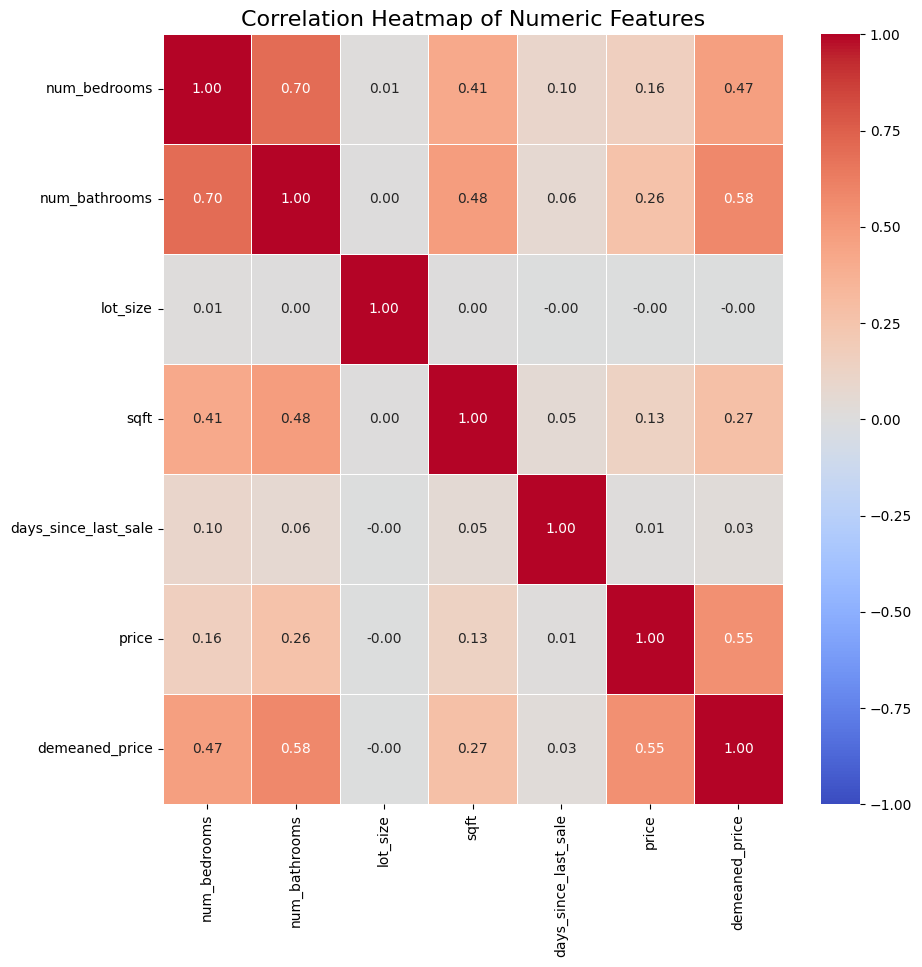

In [ ]:
dm_price_query = """WITH avg_price_df AS (
SELECT zip_code, AVG(price) AS avg_price_by_zipcode
FROM properties
GROUP BY zip_code)
SELECT id,
       properties.zip_code,
       city,
       state,
       num_bedrooms,
       num_bathrooms,
       lot_size,
       sqft,
       days_since_last_sale,
       price,
       ((price - avg_price_by_zipcode)/avg_price_by_zipcode) AS demeaned_price
FROM properties
INNER JOIN avg_price_df
  ON properties.zip_code = avg_price_df.zip_code
"""
properties = ps.sqldf(dm_price_query, locals()).reset_index(drop = True)

numeric_properties = properties[['num_bedrooms', 'num_bathrooms', 'lot_size', 'sqft', "days_since_last_sale", 'price', "demeaned_price"]]
correlation_matrix = numeric_properties.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.show()

Additionally, the lot_size feature has essentially no correlation with any of the variables. Accordingly, we excluded it from the models we used.

The scatter plot shows that most of the feature variables -- which are num_bedrooms, num_bathrooms, lot_size, sqft, and days_since_last_sale -- have a positive correlation with the others. The exception to this is lot_size, which seems to have no relationship with the other variables; in other words, it is independent of the other variables, so we will exclude it from our models. In general, there aren't very strong correlations between any of the feature variables. Most prominent are the relationships between num_bedrooms and num_bathooms. Still, in order to avoid issues with multicollinearity, we ran PCA to take only the principle components of the data before fitting any models. In the next section, we run the PCA and choose the appropriate number of components.

# Initial Models

To begin with, we will fit regression models to the feature variables to try to predict de-meaned price. However, given that some of the variables in the correlation heatmap showed modest correlation, there is risk of multicollinearity if we apply the models directly. Instead, we will fit PCA to the data and use the principle components to fit the regression models.

_**Initial PCA**_

We instantiate and fit PCA on our training data and then plot the cumulative explained_variance_ratio against the number of components to decide the number of components to keep. We add a horizontal line that represents the 80% of the variance as a threshold. Since PCA is not scale-invariant, we scaled the data after splitting it into training and testing sets.

In [ ]:
# Separate dataframe into features (X) and target variable (y)
X = properties[["num_bedrooms", "num_bathrooms", "sqft", "days_since_last_sale"]]
y = properties["demeaned_price"]

# Apply a 80/20 train/test split. 80% of the data will be part of the training set, and 20% will be in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# PCA is not scale-invariant, so this step scales the features so that the data values are between 0 and 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate and Fit PCA
pca = PCA(n_components = 4)
X_train_pca = pca.fit_transform(X_train_scaled)

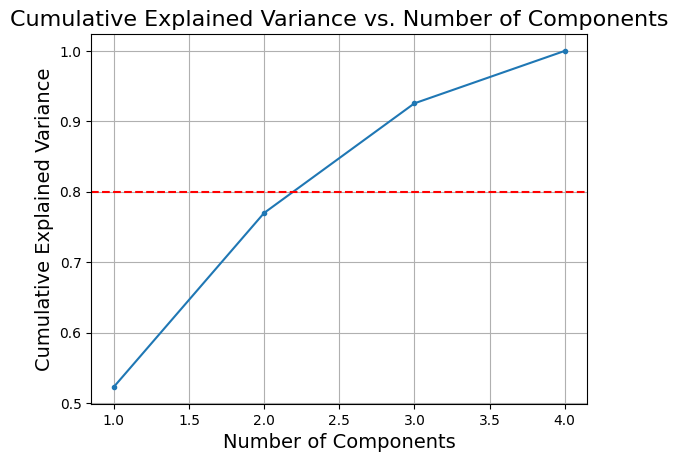

In [ ]:
# Find optimal number of components to use by plotting explained variance ratio
cev = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cev) + 1), cev, marker = ".")
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
plt.xlabel("Number of Components", fontsize=14)
plt.ylabel("Cumulative Explained Variance", fontsize=14)
plt.title("Cumulative Explained Variance vs. Number of Components", fontsize=16)
plt.grid(True)
plt.show()

At least 80% of the variance in the data is explained by the first 3 principle components. As a result, we will re-run PCA, this time using 3 components instead of 4.

_**Final PCA**_

From our initial PCA, we choose the lowest number of components that explains at least 80% of total variance in the dataset, which is 3. Using this number of components, we re-fit the PCA to obtain the result that we entered into our initial regression models.

In [ ]:
n_components = 3
pca_refit = PCA(n_components=n_components)
X_train_pca_refit = pca_refit.fit_transform(X_train_scaled)
X_test_pca_refit = pca_refit.transform(X_test_scaled)

_**Regression Modeling**_

In this section, we used the results from PCA to run regression models
We tested the performance of Linear Regression, Lasso Regression, Ridge Regression, and Elastic Net Regression (with 3 different L1 ratios) in predicting de-meaned price using the principle components of number of bedrooms, number of bathrooms, square footage, lot size, and the number of days since a property was  as input features. The noticeably high error across these models suggests the need for additional steps (incorporating regional income data, assessing relative overpricing/underpricing) in our models.

In [ ]:
# Instantiate, fit, and test our models
linear = LinearRegression()
linear.fit(X_train_pca_refit, y_train)
predictions = linear.predict(X_test_pca_refit)
mse_linear = mean_squared_error(y_test, predictions)
print("Linear Regression MSE: " + str(mse_linear))

lasso = Lasso()
lasso.fit(X_train_pca_refit, y_train)
predictions = lasso.predict(X_test_pca_refit)
mse_lasso = mean_squared_error(y_test, predictions)
print("Lasso Regression MSE: " + str(mse_lasso))

ridge = Ridge()
ridge.fit(X_train_pca_refit, y_train)
predictions = ridge.predict(X_test_pca_refit)
mse_ridge = mean_squared_error(y_test, predictions)
print("Ridge Regression MSE: " + str(mse_ridge))

potential_l1_ratios = [0.25, 0.5, 0.75]
en_mse_dict = dict({0.25: np.nan, 0.5: np.nan, 0.75: np.nan})
en_r2_dict = dict({0.25: np.nan, 0.5: np.nan, 0.75: np.nan})
for val in en_mse_dict.keys() :
  en = ElasticNet(l1_ratio = val)
  en.fit(X_train_pca_refit, y_train)
  predictions = en.predict(X_test_pca_refit)
  mse = mean_squared_error(y_test, predictions)
  r2 = r2_score(y_test, predictions)
  en_mse_dict[val] = mse
  en_r2_dict[val] = r2

for val in en_mse_dict.keys() :
  print("Elastic Net MSE (l1 = " + str(val) + "): " + str(en_mse_dict[val]))
  print("Elastic Net R-Squared (l1 = " + str(val) + "): " + str(en_r2_dict[val]))

Linear Regression MSE: 0.5176106645955965
Lasso Regression MSE: 0.8089559887881885
Ridge Regression MSE: 0.517610741031039
Elastic Net MSE (l1 = 0.25): 0.6411635312107183
Elastic Net R-Squared (l1 = 0.25): 0.20741801703747298
Elastic Net MSE (l1 = 0.5): 0.7320838503199281
Elastic Net R-Squared (l1 = 0.5): 0.09502577495987408
Elastic Net MSE (l1 = 0.75): 0.8089559887881885
Elastic Net R-Squared (l1 = 0.75): -6.402616741230105e-07


Below is a visualization that compares the mean squared error of OLS, Lasso, Ridge, and Elastic Net Regression. This visualization can give an indication the models' performance on the data to see which one is the most appropriate for our data.

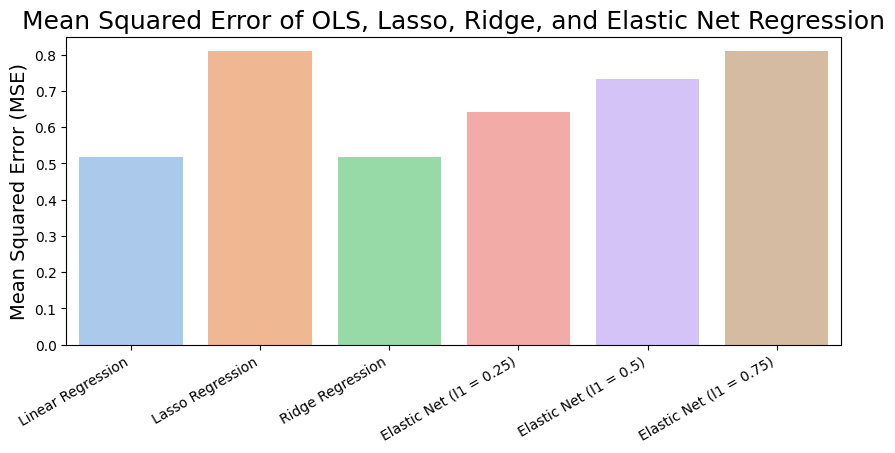

In [ ]:
# Plot predictive accuracy for each model
models = ['Linear Regression', 'Lasso Regression', 'Ridge Regression']
models += [f'Elastic Net (l1 = {l1})' for l1 in potential_l1_ratios]

mses = [mse_linear, mse_lasso, mse_ridge] + list(en_mse_dict.values())

plt.figure(figsize=(10, 4))
sns.barplot(x = models, y = mses, palette = "pastel")
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('Mean Squared Error of OLS, Lasso, Ridge, and Elastic Net Regression', fontsize=18)
plt.xticks(rotation=30, ha='right')
plt.show()

Based on this plot, it appears that the OLS Linear Regression and Ridge Regression performed better than the Lasso and Elastic Net Regression models. They produced nearly identical Root Mean Squared Error values. However, the mean squared error values are substantial, which indicates that linear regression is likely not the best way to capture the relationships in our data.

In the next section, we incorporated data from the IRS that includes number of people in each zipcode and the number of people in each income bracket. Based on these values, we calculated the average Adjusted Gross Income (AGI) bracket for a family in a given zipcode. Incorporating this in the data allows us to further control for locational differences.

# Incorporating IRS Income Bracket Data



The following code loads in a data frame with the number of people in each Adjusted Gross Income bracket.

In [ ]:
avg_income = pd.read_csv("zipcode_avg_income.csv")
avg_income_query = """
SELECT STATE AS state,
       zipcode,
       agi_stub AS agi_bracket,
       N2 AS num_ppl
FROM avg_income
WHERE zipcode > 0
"""
avg_income_filtered = ps.sqldf(avg_income_query, locals()).reset_index(drop = True)
avg_income_filtered

,state,zipcode,agi_bracket,num_ppl
0,AL,35004,1,1990.0
1,AL,35004,2,2400.0
2,AL,35004,3,1970.0
3,AL,35004,4,1500.0
4,AL,35004,5,2260.0
...,...,...,...,...
166141,WY,99999,2,6010.0
166142,WY,99999,3,4620.0
166143,WY,99999,4,3810.0
166144,WY,99999,5,6490.0


Now, we would like to find the average AGI bracket (between 1 and 6) for each zipcode. We find this using the simple equation: $$\text{Zipcode Average AGI Bracket} = \frac{\sum\text{(People in bracket }x \text{ in that zipcode}) * x}{\text{Total people in that zipcode}} \text{ where } x \in \{1, 2, 3, 4, 5, 6\}$$

In [ ]:
# Make a column with the num_ppl * agi_bracket indicating the num_ppl * agi_bracket for each row
avg_income_filtered['num_ppl_times_agi_bracket'] = avg_income_filtered['agi_bracket'] * avg_income_filtered['num_ppl']

# Find total people in each zipcode
num_ppl_by_zipcode = avg_income_filtered.groupby('zipcode')['num_ppl'].sum()

# Find the sum of the 6 different (num_ppl * agi_bracket) values for each zipcode
sum_ppl_times_agi_by_zipcode = avg_income_filtered.groupby('zipcode')['num_ppl_times_agi_bracket'].sum()

# Merge the calculated columns in one dataframe
avg_income_filtered = avg_income_filtered.merge(num_ppl_by_zipcode, on='zipcode')
avg_income_filtered = avg_income_filtered.merge(sum_ppl_times_agi_by_zipcode, on='zipcode')

# Conduct the calculation indicated above to find the average AGI bracket for each region
avg_income_filtered['avg_agi_bracket'] = avg_income_filtered['num_ppl_times_agi_bracket_y'] / avg_income_filtered['num_ppl_y']
avg_income_filtered = avg_income_filtered[['state', 'zipcode', 'avg_agi_bracket']].drop_duplicates()
avg_income_filtered.reset_index(inplace=True, drop=True)
avg_income_filtered.rename(columns={'avg_agi_bracket' : 'agi_bracket'}, inplace=True)

avg_income_filtered

,state,zipcode,agi_bracket
0,AL,35004,3.046154
1,AL,35005,2.225443
2,AL,35006,2.812000
3,AL,35007,3.090226
4,AL,35010,2.516890
...,...,...,...
27688,WY,83122,2.825000
27689,WY,83126,3.387755
27690,WY,83127,3.502632
27691,WY,83128,3.487179


The code below merges properties_df with avg_income_filtered to have AGI bracket data alongside the data collected beforehand.

In [ ]:
# Merge the properties dataframe with the avg_income_filtered dataframe
merge_query = """
SELECT p.id,
       zip_code,
       city,
       p.state,
       num_bedrooms,
       num_bathrooms,
       sqft,
       lot_size,
       days_since_last_sale,
       aif.agi_bracket,
       price,
       demeaned_price
FROM properties p
INNER JOIN avg_income_filtered aif
  ON p.zip_code = aif.zipcode
"""
merged_df = ps.sqldf(merge_query, locals()).reset_index(drop = True)

merged_df

,id,zip_code,city,state,num_bedrooms,num_bathrooms,sqft,lot_size,days_since_last_sale,agi_bracket,price,demeaned_price
0,061896,1001.0,Agawam,Massachusetts,2,2,892.0,0.36,1683,3.170668,169900.0,-0.364882
1,315352,1001.0,Agawam,Massachusetts,3,3,2314.0,0.45,3453,3.170668,525000.0,0.962549
2,561993,1001.0,Agawam,Massachusetts,3,2,1276.0,0.36,4074,3.170668,289900.0,0.083701
3,548684,1001.0,Agawam,Massachusetts,2,3,1229.0,0.36,2740,3.170668,239900.0,-0.103208
4,581350,1001.0,Agawam,Massachusetts,2,1,860.0,0.36,9821,3.170668,249900.0,-0.065827
...,...,...,...,...,...,...,...,...,...,...,...,...
606399,110268,12198.0,North Greenbush,New York,3,2,2290.0,2.85,5575,3.660221,110000.0,-0.616842
606400,259178,12198.0,North Greenbush,New York,4,3,3082.0,1.85,2648,3.660221,665000.0,1.316363
606401,365838,12198.0,North Greenbush,New York,2,1,1521.0,2.10,2179,3.660221,75000.0,-0.738756
606402,131932,12198.0,Wynantskill,New York,3,3,2457.0,0.60,3665,3.660221,435000.0,0.515215


The following creates a countplot that compares the average house size in the zip codes with the highest average house size. Note that there is a condition that the zip code has greater than 50 properties.

In [ ]:
top_ten_query = """ WITH intermed AS (
SELECT zip_code, AVG(sqft) AS avg_sqft, COUNT(id) AS count_id
FROM properties
GROUP BY zip_code
HAVING count_id > 50
ORDER BY avg_sqft DESC
LIMIT 10)
SELECT zip_code, avg_sqft
FROM intermed
"""
top_ten_properties = ps.sqldf(top_ten_query, locals()).reset_index(drop = True)
top_ten_properties["zip_code"] = top_ten_properties["zip_code"].apply(lambda x : clean_zipcode(x))

NameError: ignored

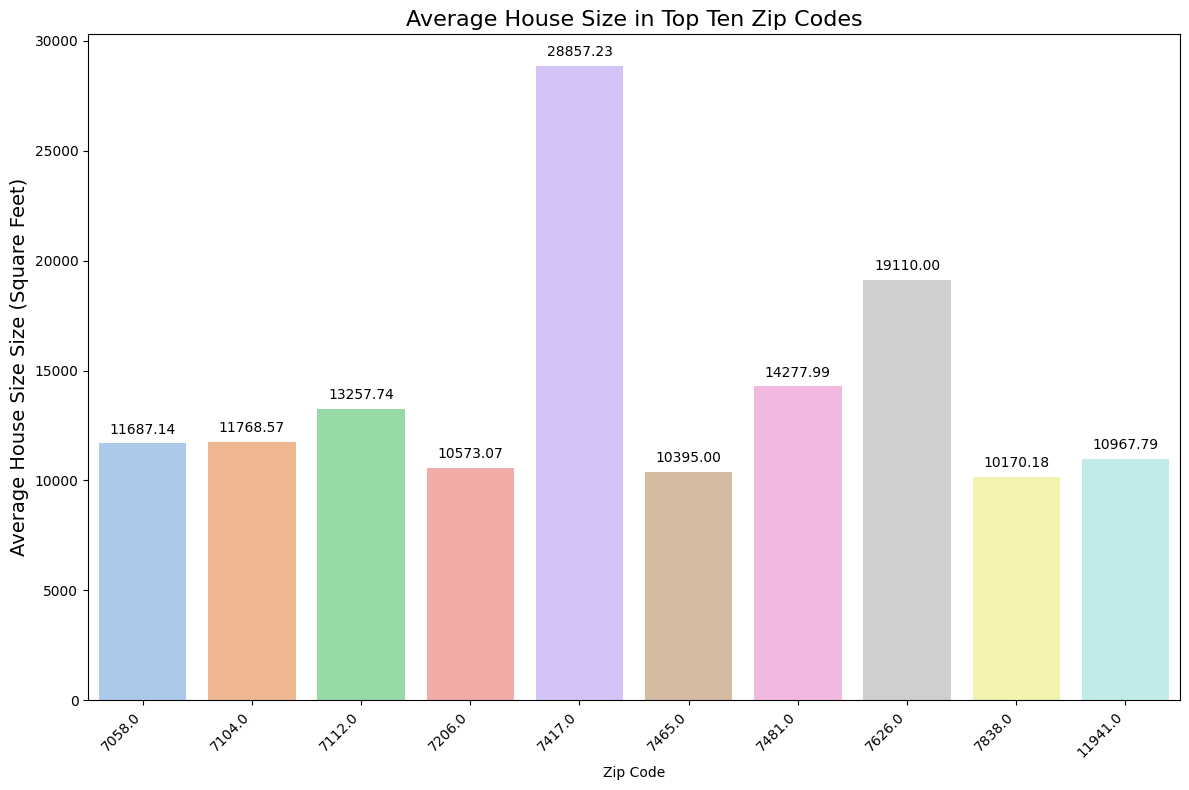

In [ ]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=top_ten_properties['zip_code'], y=top_ten_properties['avg_sqft'], palette='pastel')

for p in ax.patches:
  ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Zip Code')
plt.ylabel('Average House Size Size (Square Feet)', fontsize=14)
plt.title('Average House Size in Top Ten Zip Codes', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

These zipcodes are not particularly informative, so we have mapped out the zip codes with the largest houses, on average, in the code below:

In [ ]:
nomi = pgeocode.Nominatim('us')

top_ten_properties['Latitude'] = (nomi.query_postal_code(top_ten_properties['zip_code'].tolist()).latitude)
top_ten_properties['Longitude'] = (nomi.query_postal_code(top_ten_properties['zip_code'].tolist()).longitude)

fig = go.Figure(data=go.Scattergeo(
        lon = top_ten_properties['Longitude'],
        lat = top_ten_properties['Latitude'],
        text = top_ten_properties['zip_code'],
        hoverinfo = "text",
        mode = 'markers',
        marker = dict(size = 20,
                      opacity = 0.8,
                      reversescale = False,
                      autocolorscale = False,
                      symbol = "circle",
                      line = dict(width = 1, color = 'rgba(102, 102, 102)'),
                      colorscale = "Blues",
                      cmin = top_ten_properties["avg_sqft"].min(),
                      color = top_ten_properties["avg_sqft"],
                      cmax = top_ten_properties["avg_sqft"].max(),
                      colorbar_title="Average House Size (Square Feet)")
        ))
fig.update_geos(projection_type = "mercator",
                center = dict(lon = -74, lat = 41),
                lataxis_range = [33, 38],
                lonaxis_range=[-74, -70],
                showcountries = True,
                showsubunits = True,
                subunitcolor = "Black",
                countrycolor = "Black",
                showcoastlines = True,
                landcolor = "darkgreen",
                showocean = True,
                oceancolor = "lightblue"
)

fig.update_layout(title = 'Zip Codes With Largest Listed Houses (Zoomed into NYC Metro Area)',
                  geo = dict(showframe = False),
                  autosize = False,
                  width = 1000,
                  height = 800)
fig.show()

The following creates a countplot that compares the median house prices in the states that have the highest median house price. Note there is the condition that the state must have greater than 1000 properties.

In [ ]:
top_ten_price = properties[['state', 'price', 'id']]
top_ten_price = top_ten_price.groupby('state').agg({'price' : "median", 'id' : "count"})
top_ten_price = top_ten_price[top_ten_price['id'] > 1000].reset_index()
top_ten_price = top_ten_price.sort_values(by='price', ascending=False).reset_index().head(10)
top_ten_price = top_ten_price[['state', 'price']]
top_ten_price

,state,price
0,New York,699000.0
1,Massachusetts,599000.0
2,New Jersey,460000.0
3,New Hampshire,400000.0
4,Rhode Island,359900.0
5,Connecticut,313500.0
6,Maine,300000.0
7,Vermont,292500.0
8,Pennsylvania,280000.0
9,Delaware,275000.0


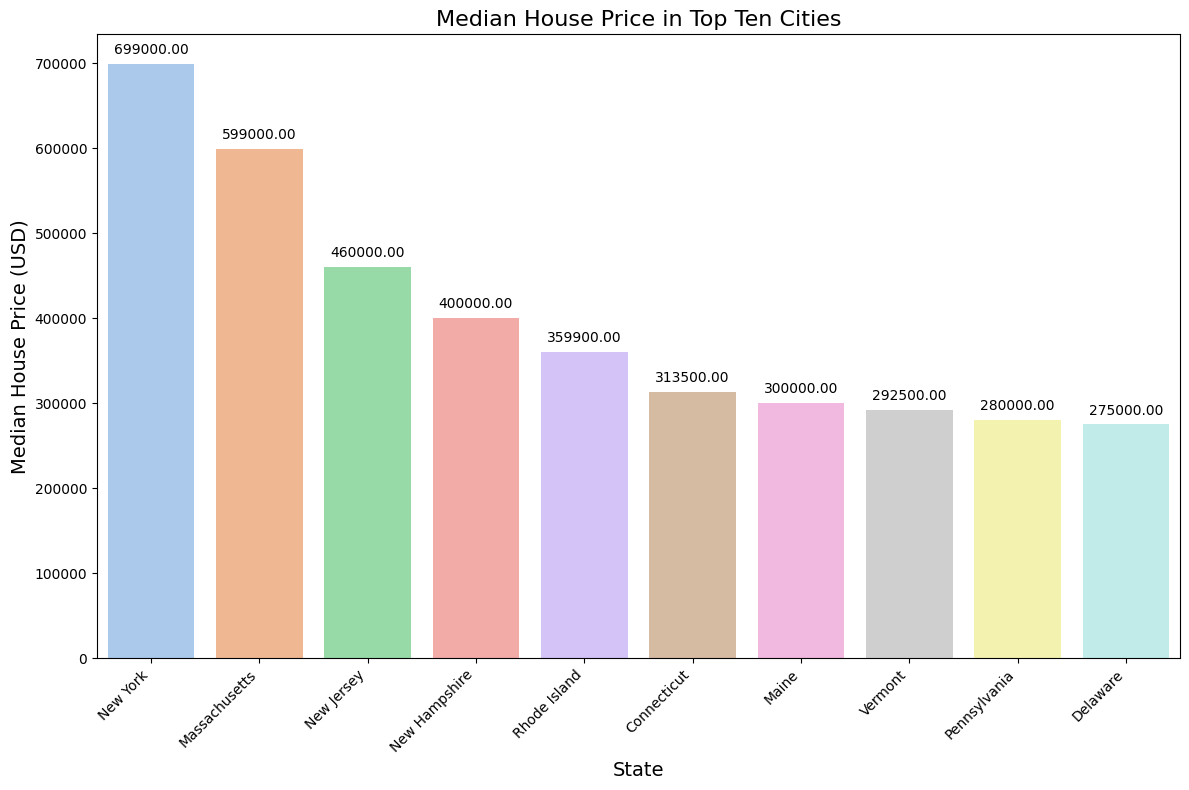

In [ ]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=top_ten_price['state'], y=top_ten_price['price'], palette='pastel')

for p in ax.patches:
  ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xlabel('State', fontsize=14)
plt.ylabel('Median House Price (USD)', fontsize=14)
plt.title('Median House Price in Top Ten Cities', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

# Incorporating Zillow Home Value Index (ZHVI)

At this point, we realized that de-meaned home prices only tell a part of the story. These values are not particularly useful; if the mean listed home price in a region is unreasonably high or low, using de-meaned price as the variable to predict will obscure whether the de-meaned price is truly a good representation of how well a home is priced. This led us to turn to the Zillow dataset. This data provided Zillow Home Value Index (ZHVI) estimates for many zip codes throughout the nation, separated by number of bedrooms. Luckily, our realtor.com dataset had number of bedrooms as one of its features as well, which enabled us to provide more precise comparisons of properties with the expected index according to Zillow. A more detailed discussion of how we are using these data/comparisons is provided after we plot the relationships between the ZHVI and the average Adjusted Gross Income brackets for each subset of data.

The code below joins the one bedroom houses in the realtor.com data set with the Zillow data for one bedroom homes, indexed by the zip code. Based on the comparisons with Zillow's home value indices, we categorize the properties as overpriced, underpriced, or reasonably priced (detailed explanation of this categorization follows).

In [ ]:
one_bedroom = properties[properties["num_bedrooms"] == 1]
one_bed = pd.read_csv("one_bedroom_zhvi.csv")
regions = pd.read_csv("zillow_regions.csv")
regions = regions[regions["region_type"] == "zip"]
regions = regions.drop(columns = "region_type", axis = 1)
regions["region"] = regions["region"].apply(lambda x: x.split(";")[0])
regions = regions.rename({"region" : "zip_code"}, axis = 1).reset_index(drop = True)
one_bed_zip = one_bed.merge(regions, left_on = "RegionID", right_on = "region_id", how = "inner")
one_bed_zip = one_bed_zip.drop(columns = ["RegionID", "RegionName", "RegionType", "StateName", "State", "City", "Metro", "CountyName", "region_id"])
one_zip = one_bed_zip.pop("zip_code")
one_bed_zip.insert(0, "zip_code", one_zip)
one_bed_zip["zip_code"] = one_bed_zip["zip_code"].apply(lambda x: float(x))
one_bedroom = one_bedroom.merge(one_bed_zip, on = "zip_code", how = "inner")
one_bedroom = one_bedroom[["id", "zip_code", "city", "state", "num_bedrooms", "num_bathrooms", "sqft", "lot_size", "price", "days_since_last_sale", "2023-10-31"]]
one_bedroom.rename(columns = {"2023-10-31" : "Zillow_Market_Value_Prediction"}, inplace = True)
one_bedroom["market_comparison"] = one_bedroom["price"] - one_bedroom["Zillow_Market_Value_Prediction"]
one_bedroom["price_differential_pct"] = one_bedroom["market_comparison"]/one_bedroom["Zillow_Market_Value_Prediction"]
one_bedroom["overpriced"] = one_bedroom["price_differential_pct"].apply(lambda x: x > 0.1)
one_bedroom["underpriced"] = one_bedroom["price_differential_pct"].apply(lambda x: x*-1 > 0.1)
one_bedroom["reasonably priced"] =  ~(one_bedroom["overpriced"] | one_bedroom["underpriced"])
one_bedroom

,id,zip_code,city,state,num_bedrooms,num_bathrooms,sqft,lot_size,price,days_since_last_sale,Zillow_Market_Value_Prediction,market_comparison,price_differential_pct,overpriced,underpriced,reasonably priced
0,402493,1060.0,Northampton,Massachusetts,1,1,773.0,0.12,299000.0,1613,251378.377803,47621.622197,0.189442,True,False,False
1,329087,1060.0,Northampton,Massachusetts,1,1,773.0,0.12,299000.0,1613,251378.377803,47621.622197,0.189442,True,False,False
2,103617,1060.0,Northampton,Massachusetts,1,1,773.0,0.12,299000.0,1613,251378.377803,47621.622197,0.189442,True,False,False
3,167012,1060.0,Northampton,Massachusetts,1,1,773.0,0.12,299000.0,1613,251378.377803,47621.622197,0.189442,True,False,False
4,535729,1060.0,Northampton,Massachusetts,1,1,773.0,0.12,299000.0,1613,251378.377803,47621.622197,0.189442,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61920,490025,12477.0,Saugerties,New York,1,1,910.0,0.46,99900.0,7368,275795.527105,-175895.527105,-0.637775,False,True,False
61921,288998,12477.0,Saugerties,New York,1,1,908.0,0.25,259000.0,3711,275795.527105,-16795.527105,-0.060898,False,False,True
61922,000637,12572.0,Rhinebeck,New York,1,2,1183.0,0.18,390000.0,2921,416077.348090,-26077.348090,-0.062674,False,False,True
61923,029984,12572.0,Rhinebeck,New York,1,2,1183.0,0.18,390000.0,2921,416077.348090,-26077.348090,-0.062674,False,False,True


The code below joins the two bedroom houses in the realtor.com data set with the Zillow data for two bedroom homes, indexed by the zip code. Based on the comparisons with Zillow's home value indices, we categorize the properties as overpriced, underpriced, or reasonably priced (detailed explanation of this categorization follows).

In [ ]:
two_bedroom = properties[properties["num_bedrooms"] == 2] # subset to only those properties with one bedroom
two_bed = pd.read_csv("two_bedroom_zhvi.csv")
two_bed_zip = two_bed.merge(regions, left_on = "RegionID", right_on = "region_id", how = "inner")
two_bed_zip = two_bed_zip.drop(columns = ["RegionID", "RegionName", "RegionType", "StateName", "State", "City", "Metro", "CountyName", "region_id"])
two_zip = two_bed_zip.pop("zip_code")
two_bed_zip.insert(0, "zip_code", two_zip)
two_bed_zip["zip_code"] = two_bed_zip["zip_code"].apply(lambda x: float(x))
two_bedroom = two_bedroom.merge(two_bed_zip, on = "zip_code", how = "inner")
two_bedroom = two_bedroom[["id", "zip_code", "city", "state", "num_bedrooms", "num_bathrooms", "sqft", "lot_size", "price", "days_since_last_sale", "2023-10-31"]]
two_bedroom.rename(columns = {"2023-10-31" : "Zillow_Market_Value_Prediction"}, inplace = True)
two_bedroom["market_comparison"] = two_bedroom["price"] - two_bedroom["Zillow_Market_Value_Prediction"]
two_bedroom["price_differential_pct"] = two_bedroom["market_comparison"]/two_bedroom["Zillow_Market_Value_Prediction"]
two_bedroom["overpriced"] = two_bedroom["price_differential_pct"].apply(lambda x: x > 0.1)
two_bedroom["underpriced"] = two_bedroom["price_differential_pct"].apply(lambda x: x*-1 > 0.1)
two_bedroom["reasonably priced"] =  ~(two_bedroom["overpriced"] | two_bedroom["underpriced"])
two_bedroom

,id,zip_code,city,state,num_bedrooms,num_bathrooms,sqft,lot_size,price,days_since_last_sale,Zillow_Market_Value_Prediction,market_comparison,price_differential_pct,overpriced,underpriced,reasonably priced
0,061896,1001.0,Agawam,Massachusetts,2,2,892.0,0.36,169900.0,1683,250791.178699,-80891.178699,-0.322544,False,True,False
1,548684,1001.0,Agawam,Massachusetts,2,3,1229.0,0.36,239900.0,2740,250791.178699,-10891.178699,-0.043427,False,False,True
2,581350,1001.0,Agawam,Massachusetts,2,1,860.0,0.36,249900.0,9821,250791.178699,-891.178699,-0.003553,False,False,True
3,396198,1001.0,Agawam,Massachusetts,2,2,1056.0,0.36,175000.0,1548,250791.178699,-75791.178699,-0.302208,False,True,False
4,210569,1001.0,Agawam,Massachusetts,2,2,960.0,0.36,195000.0,1820,250791.178699,-55791.178699,-0.222461,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108366,535888,12842.0,Indian Lake,New York,2,1,748.0,0.70,219900.0,2060,259529.007466,-39629.007466,-0.152696,False,True,False
108367,020874,12842.0,Indian Lake,New York,2,2,1372.0,0.66,35000.0,1948,259529.007466,-224529.007466,-0.865140,False,True,False
108368,174166,12442.0,Hunter,New York,2,1,1164.0,2.60,369000.0,602,354609.649210,14390.350790,0.040581,False,False,True
108369,555083,12442.0,Hunter,New York,2,1,1164.0,2.60,369000.0,602,354609.649210,14390.350790,0.040581,False,False,True


The code below joins the three bedroom houses in the realtor.com data set with the Zillow data for three bedroom homes, indexed by the zip code. Based on the comparisons with Zillow's home value indices, we categorize the properties as overpriced, underpriced, or reasonably priced (detailed explanation of this categorization follows).

In [ ]:
three_bedroom = properties[properties["num_bedrooms"] == 3]
three_bed = pd.read_csv("three_bedroom_zhvi.csv")
three_bed_zip = three_bed.merge(regions, left_on = "RegionID", right_on = "region_id", how = "inner")
three_bed_zip = three_bed_zip.drop(columns = ["RegionID", "RegionName", "RegionType", "StateName", "State", "City", "Metro", "CountyName", "region_id"])
three_zip = three_bed_zip.pop("zip_code")
three_bed_zip.insert(0, "zip_code", three_zip)
three_bed_zip["zip_code"] = three_bed_zip["zip_code"].apply(lambda x: float(x))
three_bedroom = three_bedroom.merge(three_bed_zip, on = "zip_code", how = "inner")
three_bedroom = three_bedroom[["id", "zip_code", "city", "state", "num_bedrooms", "num_bathrooms", "sqft", "lot_size", "price", "days_since_last_sale", "2023-10-31"]]
three_bedroom.rename(columns = {"2023-10-31" : "Zillow_Market_Value_Prediction"}, inplace = True)
three_bedroom["market_comparison"] = three_bedroom["price"] - three_bedroom["Zillow_Market_Value_Prediction"]
three_bedroom["price_differential_pct"] = three_bedroom["market_comparison"]/three_bedroom["Zillow_Market_Value_Prediction"]
three_bedroom["overpriced"] = three_bedroom["price_differential_pct"].apply(lambda x: x > 0.1)
three_bedroom["underpriced"] = three_bedroom["price_differential_pct"].apply(lambda x: x*-1 > 0.1)
three_bedroom["reasonably priced"] =  ~(three_bedroom["overpriced"] | three_bedroom["underpriced"])
three_bedroom

,id,zip_code,city,state,num_bedrooms,num_bathrooms,sqft,lot_size,price,days_since_last_sale,Zillow_Market_Value_Prediction,market_comparison,price_differential_pct,overpriced,underpriced,reasonably priced
0,315352,1001.0,Agawam,Massachusetts,3,3,2314.0,0.45,525000.0,3453,324346.404775,2.006536e+05,0.618640,True,False,False
1,561993,1001.0,Agawam,Massachusetts,3,2,1276.0,0.36,289900.0,4074,324346.404775,-3.444640e+04,-0.106203,False,True,False
2,273576,1001.0,Agawam,Massachusetts,3,2,1476.0,0.46,384900.0,13532,324346.404775,6.055360e+04,0.186694,True,False,False
3,568920,1001.0,Agawam,Massachusetts,3,2,1968.0,1.76,199999.0,5558,324346.404775,-1.243474e+05,-0.383378,False,True,False
4,614922,1001.0,Agawam,Massachusetts,3,2,1968.0,1.76,199999.0,5558,324346.404775,-1.243474e+05,-0.383378,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183108,020968,12444.0,Jewett,New York,3,3,3492.0,12.55,1499000.0,583,484299.317442,1.014701e+06,2.095193,True,False,False
183109,127337,12885.0,Warrensburg,New York,3,2,1680.0,0.23,249000.0,2332,233798.356220,1.520164e+04,0.065020,False,False,True
183110,465806,12822.0,Corinth,New York,3,3,2008.0,0.63,249900.0,1450,244302.644062,5.597356e+03,0.022912,False,False,True
183111,021067,12822.0,Corinth,New York,3,3,2008.0,4.10,39900.0,855,244302.644062,-2.044026e+05,-0.836678,False,True,False


The code below joins the four bedroom houses in the realtor.com data set with the Zillow data for four bedroom homes, indexed by the zip code. Based on the comparisons with Zillow's home value indices, we categorize the properties as overpriced, underpriced, or reasonably priced (detailed explanation of this categorization follows):

In [ ]:
four_bedroom = properties[properties["num_bedrooms"] == 4]
four_bed = pd.read_csv("four_bedroom_zhvi.csv")
four_bed_zip = four_bed.merge(regions, left_on = "RegionID", right_on = "region_id", how = "inner")
four_bed_zip = four_bed_zip.drop(columns = ["RegionID", "RegionName", "RegionType", "StateName", "State", "City", "Metro", "CountyName", "region_id"])
four_zip = four_bed_zip.pop("zip_code")
four_bed_zip.insert(0, "zip_code", four_zip)
four_bed_zip["zip_code"] = four_bed_zip["zip_code"].apply(lambda x: float(x))
four_bedroom = four_bedroom.merge(four_bed_zip, on = "zip_code", how = "inner")
four_bedroom = four_bedroom[["id", "zip_code", "city", "state", "num_bedrooms", "num_bathrooms", "sqft", "lot_size", "price", "days_since_last_sale", "2023-10-31"]]
four_bedroom.rename(columns = {"2023-10-31" : "Zillow_Market_Value_Prediction"}, inplace = True)
four_bedroom["market_comparison"] = four_bedroom["price"] - four_bedroom["Zillow_Market_Value_Prediction"]
four_bedroom["price_differential_pct"] = four_bedroom["market_comparison"]/four_bedroom["Zillow_Market_Value_Prediction"]
four_bedroom["overpriced"] = four_bedroom["price_differential_pct"].apply(lambda x: x > 0.1)
four_bedroom["underpriced"] = four_bedroom["price_differential_pct"].apply(lambda x: x*-1 > 0.1)
four_bedroom["reasonably priced"] =  ~(four_bedroom["overpriced"] | four_bedroom["underpriced"])
four_bedroom

,id,zip_code,city,state,num_bedrooms,num_bathrooms,sqft,lot_size,price,days_since_last_sale,Zillow_Market_Value_Prediction,market_comparison,price_differential_pct,overpriced,underpriced,reasonably priced
0,160064,1002.0,Pelham,Massachusetts,4,2,1607.0,2.00,419000.0,6710,567761.013394,-148761.013394,-0.262013,False,True,False
1,497175,1002.0,Amherst,Massachusetts,4,3,2847.0,0.56,745000.0,11489,567761.013394,177238.986606,0.312172,True,False,False
2,558069,1002.0,Pelham,Massachusetts,4,4,4366.0,1.50,875000.0,10010,567761.013394,307238.986606,0.541141,True,False,False
3,488429,1002.0,Amherst,Massachusetts,4,4,3879.0,0.77,699900.0,11076,567761.013394,132138.986606,0.232737,True,False,False
4,340943,1002.0,Amherst,Massachusetts,4,2,1814.0,0.49,415000.0,9657,567761.013394,-152761.013394,-0.269059,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120709,506733,13365.0,Little Falls,New York,4,2,4480.0,0.17,159900.0,2110,157217.774100,2682.225900,0.017061,False,False,True
120710,316782,13365.0,Little Falls,New York,4,1,1758.0,0.17,124900.0,7938,157217.774100,-32317.774100,-0.205561,False,True,False
120711,177946,12155.0,Schenevus,New York,4,2,3948.0,5.77,599900.0,1527,196667.938573,403232.061427,2.050319,True,False,False
120712,485287,12155.0,Schenevus,New York,4,2,3948.0,5.77,599900.0,1527,196667.938573,403232.061427,2.050319,True,False,False


The Zillow index groups all properties that have at least 5 bedrooms as a single category when computing its estimations. Our data includes properties that have as many as 20 bedrooms, but these represent a small portion of our data, so it is reasonable to include these records when joining with the Zillow data. The code below does this joining. Based on the comparisons with Zillow's home value indices, we categorize the properties as overpriced, underpriced, or reasonably priced.

In [ ]:
five_plus_bedroom = properties[properties["num_bedrooms"] >= 5]
five_plus_bed = pd.read_csv("five_plus_bedroom_zhvi.csv")
five_plus_bed_zip = five_plus_bed.merge(regions, left_on = "RegionID", right_on = "region_id", how = "inner")
five_plus_bed_zip = five_plus_bed_zip.drop(columns = ["RegionID", "RegionName", "RegionType", "StateName", "State", "City", "Metro", "CountyName", "region_id"])
five_plus_zip = five_plus_bed_zip.pop("zip_code")
five_plus_bed_zip.insert(0, "zip_code", five_plus_zip)
five_plus_bed_zip["zip_code"] = five_plus_bed_zip["zip_code"].apply(lambda x: float(x))
five_plus_bedroom = five_plus_bedroom.merge(five_plus_bed_zip, on = "zip_code", how = "inner")
five_plus_bedroom = five_plus_bedroom[["id", "zip_code", "city", "state", "num_bedrooms", "num_bathrooms", "sqft", "lot_size", "price", "days_since_last_sale", "2023-10-31"]]
five_plus_bedroom.rename(columns = {"2023-10-31" : "Zillow_Market_Value_Prediction"}, inplace = True)
five_plus_bedroom["market_comparison"] = five_plus_bedroom["price"] - five_plus_bedroom["Zillow_Market_Value_Prediction"]
five_plus_bedroom["price_differential_pct"] = five_plus_bedroom["market_comparison"]/five_plus_bedroom["Zillow_Market_Value_Prediction"]
five_plus_bedroom["overpriced"] = five_plus_bedroom["price_differential_pct"].apply(lambda x: x > 0.1)
five_plus_bedroom["underpriced"] = five_plus_bedroom["price_differential_pct"].apply(lambda x: x*-1 > 0.1)
five_plus_bedroom["reasonably priced"] =  ~(five_plus_bedroom["overpriced"] | five_plus_bedroom["underpriced"])
five_plus_bedroom

,id,zip_code,city,state,num_bedrooms,num_bathrooms,sqft,lot_size,price,days_since_last_sale,Zillow_Market_Value_Prediction,market_comparison,price_differential_pct,overpriced,underpriced,reasonably priced
0,309096,1002.0,Amherst,Massachusetts,5,4,2363.0,0.64,650000.0,7072,669523.917911,-19523.917911,-0.029161,False,False,True
1,024268,1002.0,Amherst,Massachusetts,5,4,2363.0,0.64,650000.0,7072,669523.917911,-19523.917911,-0.029161,False,False,True
2,098405,1002.0,Amherst,Massachusetts,5,4,2363.0,0.64,650000.0,7072,669523.917911,-19523.917911,-0.029161,False,False,True
3,067951,1002.0,Amherst,Massachusetts,5,4,2363.0,0.64,650000.0,7072,669523.917911,-19523.917911,-0.029161,False,False,True
4,267851,1002.0,Amherst,Massachusetts,5,4,2363.0,0.64,650000.0,7072,669523.917911,-19523.917911,-0.029161,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68156,441920,13365.0,Little Falls,New York,6,1,1404.0,0.17,23000.0,5005,193571.152750,-170571.152750,-0.881181,False,True,False
68157,482737,13365.0,Little Falls,New York,5,2,1578.0,0.12,169900.0,4545,193571.152750,-23671.152750,-0.122287,False,True,False
68158,613294,13365.0,Little Falls,New York,5,4,3773.0,0.13,329900.0,3186,193571.152750,136328.847250,0.704283,True,False,False
68159,105509,12442.0,Hunter,New York,8,5,2904.0,0.88,759000.0,2125,605394.991195,153605.008805,0.253727,True,False,False


In the following code block, we combine each of the individual data frames that we created from joining the realtor.com data with the Zillow data by number of bedrooms and zip code.

In [ ]:
all_props = pd.concat([one_bedroom, two_bedroom, three_bedroom, four_bedroom, five_plus_bedroom])
all_props = all_props.reset_index(drop = True)
all_props

,id,zip_code,city,state,num_bedrooms,num_bathrooms,sqft,lot_size,price,days_since_last_sale,Zillow_Market_Value_Prediction,market_comparison,price_differential_pct,overpriced,underpriced,reasonably priced
0,402493,1060.0,Northampton,Massachusetts,1,1,773.0,0.12,299000.0,1613,251378.377803,47621.622197,0.189442,True,False,False
1,329087,1060.0,Northampton,Massachusetts,1,1,773.0,0.12,299000.0,1613,251378.377803,47621.622197,0.189442,True,False,False
2,103617,1060.0,Northampton,Massachusetts,1,1,773.0,0.12,299000.0,1613,251378.377803,47621.622197,0.189442,True,False,False
3,167012,1060.0,Northampton,Massachusetts,1,1,773.0,0.12,299000.0,1613,251378.377803,47621.622197,0.189442,True,False,False
4,535729,1060.0,Northampton,Massachusetts,1,1,773.0,0.12,299000.0,1613,251378.377803,47621.622197,0.189442,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542279,441920,13365.0,Little Falls,New York,6,1,1404.0,0.17,23000.0,5005,193571.152750,-170571.152750,-0.881181,False,True,False
542280,482737,13365.0,Little Falls,New York,5,2,1578.0,0.12,169900.0,4545,193571.152750,-23671.152750,-0.122287,False,True,False
542281,613294,13365.0,Little Falls,New York,5,4,3773.0,0.13,329900.0,3186,193571.152750,136328.847250,0.704283,True,False,False
542282,105509,12442.0,Hunter,New York,8,5,2904.0,0.88,759000.0,2125,605394.991195,153605.008805,0.253727,True,False,False


In the code below, for 1-bedroom, 2-bedroom, 3-bedroom, and 4-bedroom, and 5+ bedroom homes, we plot the logarithm of each zipcode's Zillow Market Value Prediction on the y-axis and that zipcode's Adjusted Gross Income (AGI) Bracket on the x-axis. From this plot, we can recognize a distinct correlation between AGI and Market Valuation, which suggests that AGI Bracket will be a useful feature for predicting whether or not a house is overpriced.

In [ ]:
temp_df = all_props.merge(avg_income_filtered, left_on = 'zip_code', right_on = 'zipcode')

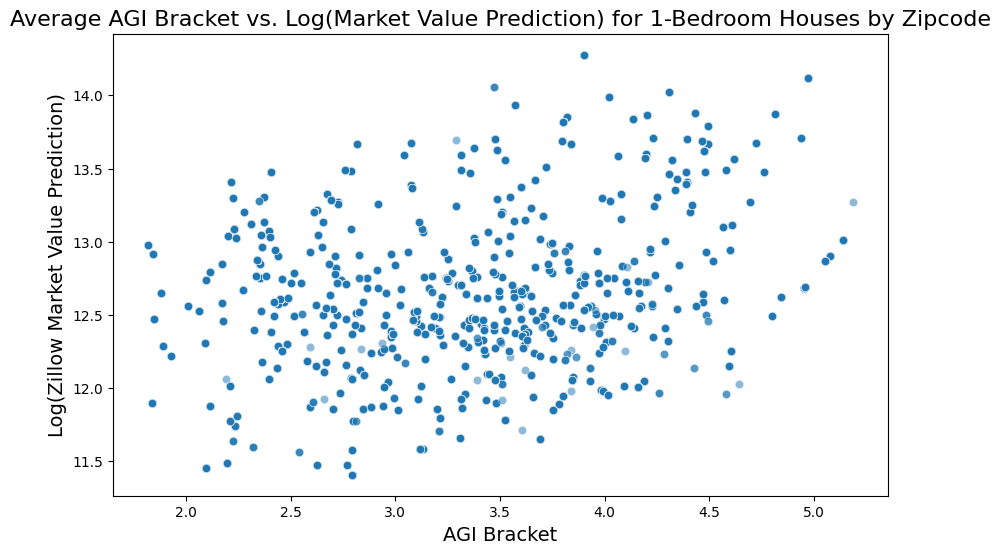

In [ ]:
# Log(Market Value) vs. AGI-Bracket for 1-Bedroom Homes
avg_agi_and_zillow_by_zipcode = temp_df[temp_df['num_bedrooms'] == 1]
agi_bracket = avg_agi_and_zillow_by_zipcode['agi_bracket']
zillow = avg_agi_and_zillow_by_zipcode['Zillow_Market_Value_Prediction']
bedrooms = avg_agi_and_zillow_by_zipcode['num_bedrooms']
plt.figure(figsize=(10, 6))
sns.scatterplot(x = agi_bracket, y = np.log1p(zillow), alpha=0.5, palette = "pastel")
plt.xlabel('Average AGI Bracket', fontsize=14)
plt.ylabel('Log(Zillow Market Value Prediction)', fontsize=14)
plt.title('Average AGI Bracket vs. Log(Market Value Prediction) for 1-Bedroom Houses by Zipcode', fontsize=16)
plt.show()

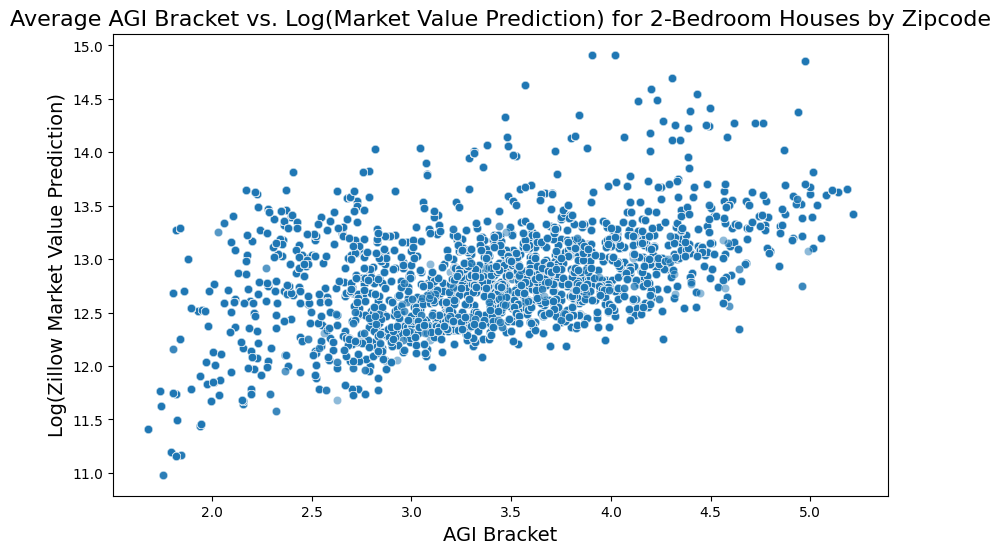

In [ ]:
# Log(Market Value) vs. AGI-Bracket for 2-Bedroom Homes
avg_agi_and_zillow_by_zipcode = temp_df[temp_df['num_bedrooms'] == 2]
agi_bracket = avg_agi_and_zillow_by_zipcode['agi_bracket']
zillow = avg_agi_and_zillow_by_zipcode['Zillow_Market_Value_Prediction']
bedrooms = avg_agi_and_zillow_by_zipcode['num_bedrooms']
plt.figure(figsize=(10, 6))
sns.scatterplot(x = agi_bracket, y = np.log1p(zillow), alpha=0.5, palette = "pastel")
plt.xlabel('Average AGI Bracket', fontsize=14)
plt.ylabel('Log(Zillow Market Value Prediction)', fontsize=14)
plt.title('Average AGI Bracket vs. Log(Market Value Prediction) for 2-Bedroom Houses by Zipcode', fontsize=16)
plt.show()

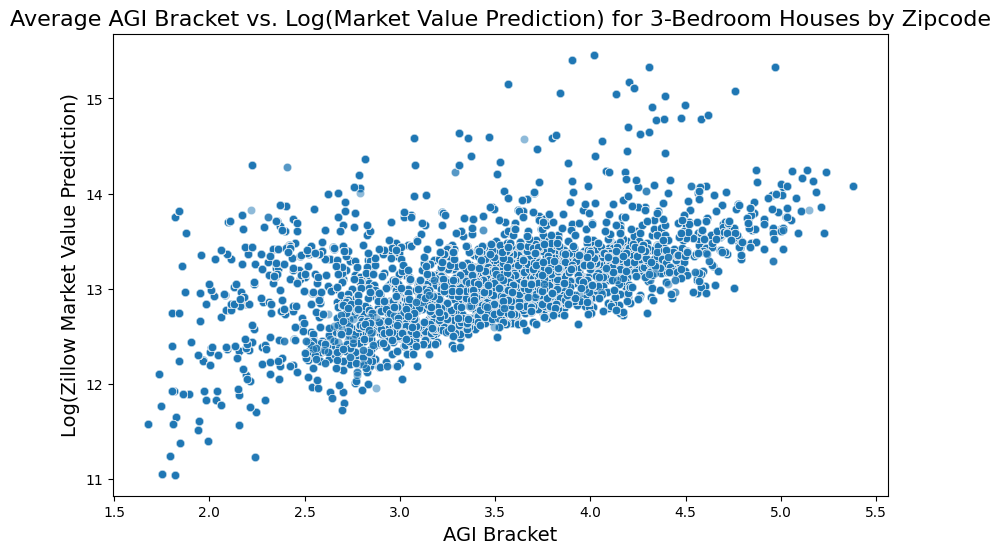

In [ ]:
# Log(Market Value) vs. AGI-Bracket for 3-Bedroom Homes
avg_agi_and_zillow_by_zipcode = temp_df[temp_df['num_bedrooms'] == 3]
agi_bracket = avg_agi_and_zillow_by_zipcode['agi_bracket']
zillow = avg_agi_and_zillow_by_zipcode['Zillow_Market_Value_Prediction']
bedrooms = avg_agi_and_zillow_by_zipcode['num_bedrooms']
plt.figure(figsize=(10, 6))
sns.scatterplot(x = agi_bracket, y = np.log1p(zillow), alpha=0.5, palette = "pastel")
plt.xlabel('Average AGI Bracket', fontsize=14)
plt.ylabel('Log(Zillow Market Value Prediction)', fontsize=14)
plt.title('Average AGI Bracket vs. Log(Market Value Prediction) for 3-Bedroom Houses by Zipcode', fontsize=16)
plt.show()

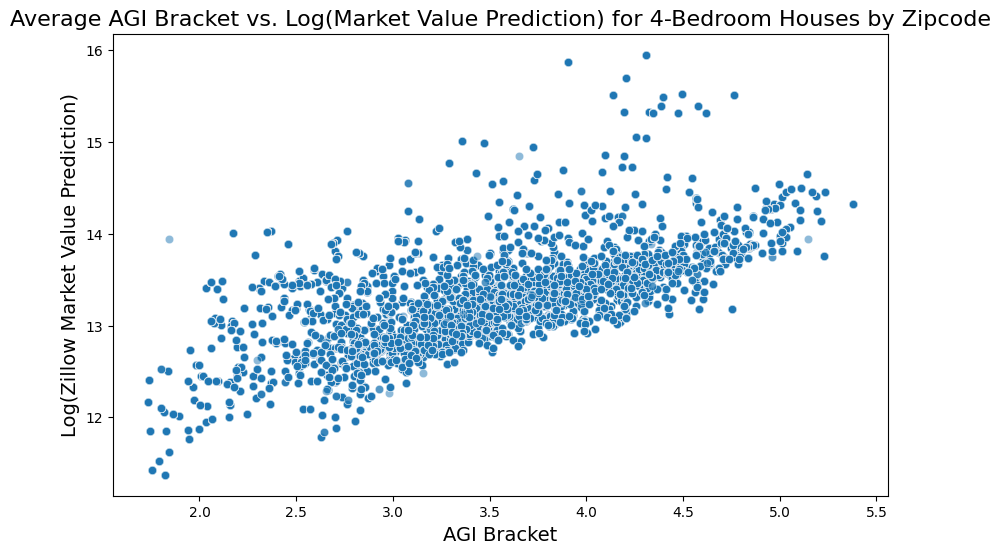

In [ ]:
# Log(Market Value) vs. AGI-Bracket for 4-Bedroom Homes
avg_agi_and_zillow_by_zipcode = temp_df[temp_df['num_bedrooms'] == 4]
agi_bracket = avg_agi_and_zillow_by_zipcode['agi_bracket']
zillow = avg_agi_and_zillow_by_zipcode['Zillow_Market_Value_Prediction']
bedrooms = avg_agi_and_zillow_by_zipcode['num_bedrooms']
plt.figure(figsize=(10, 6))
sns.scatterplot(x = agi_bracket, y = np.log1p(zillow), alpha=0.5, palette = "pastel")
plt.xlabel('Average AGI Bracket', fontsize=14)
plt.ylabel('Log(Zillow Market Value Prediction)', fontsize=14)
plt.title('Average AGI Bracket vs. Log(Market Value Prediction) for 4-Bedroom Houses by Zipcode', fontsize=16)
plt.show()

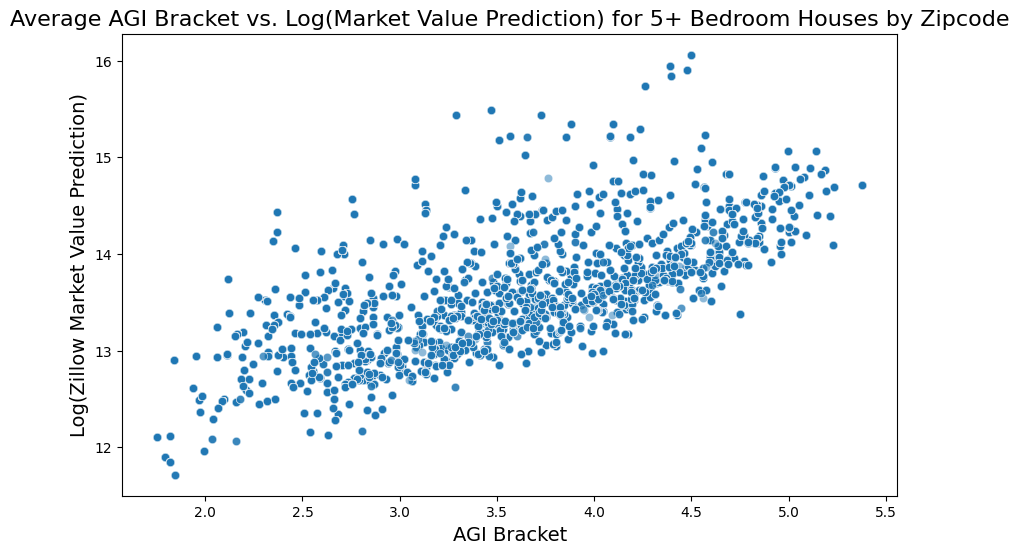

In [ ]:
# Log(Market Value) vs. AGI-Bracket for 5+ Bedroom Homes
avg_agi_and_zillow_by_zipcode = temp_df[temp_df['num_bedrooms'] >= 5]
agi_bracket = avg_agi_and_zillow_by_zipcode['agi_bracket']
zillow = avg_agi_and_zillow_by_zipcode['Zillow_Market_Value_Prediction']
bedrooms = avg_agi_and_zillow_by_zipcode['num_bedrooms']
plt.figure(figsize=(10, 6))
sns.scatterplot(x = agi_bracket, y = np.log1p(zillow), alpha=0.5, palette = "pastel")
plt.xlabel('Average AGI Bracket', fontsize=14)
plt.ylabel('Log(Zillow Market Value Prediction)', fontsize=14)
plt.title('Average AGI Bracket vs. Log(Market Value Prediction) for 5+ Bedroom Houses by Zipcode', fontsize=16)
plt.show()

Unsurprisingly, each of these plots shows that average income bracket for a given zip code is clearly related to Zillow's market value prediction. As such, it will be useful to include the average income bracket as a feature variable in our model, allowing us to account for this in our classifications.

A price differential percentage is, on its own, hard to interpret. In order to more explicitly determine whether a home is well priced given its location and number of bedrooms, we used a common metric used to categorize homes according to the quality of their listed price. Naturally, very few homes are going to be exactly equal to the market value; the simplified features of our data set obscure some unobserved characteristics about a home that we, as analysts, can't use in our calculations. As such, we allowed for some error in our categorizations. If a home's listed price is within 10% of the home value index for similar homes, then it gets categorized as "Reasonably Priced". If a home's listed price falls outside of that error bound, it gets categorized as "Overpriced" or "Underpriced", appropriately.

In [ ]:
all_props["overpriced"] = all_props["overpriced"].apply(lambda x: int(x))
all_props["underpriced"] = all_props["underpriced"].apply(lambda x : int(x))
all_props["reasonably priced"] = all_props["reasonably priced"].apply(lambda x : int(x))
all_props["zip_code"] = all_props["zip_code"].apply(lambda x: clean_zipcode(x))
all_props

The following creates a barplot that compares the zipcodes that have the most overpriced properties.

In [ ]:
overpriced_query = """
SELECT zip_code, AVG(price_differential_pct) AS avg_pct_overpriced
FROM all_props
GROUP BY zip_code
ORDER BY avg_pct_overpriced DESC
LIMIT 10
"""

most_overpriced_zipcodes = ps.sqldf(overpriced_query, locals())

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=most_overpriced_zipcodes['zip_code'], y=most_overpriced_zipcodes['avg_pct_overpriced'], palette='pastel')

for p in ax.patches:
  ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xlabel('Zip Code', fontsize=14)
plt.ylabel('Average Percentage Overpriced', fontsize=14)
plt.title('Most Overpriced Zipcodes', fontsize=16)
plt.tight_layout()
plt.show()

Interestingly, most zip codes (with the obvious exception of 12538 -- corresponding to Hyde Park, NY) are not extremely overpriced, on average. Even the zipcodes with the highest average percentage difference between the actual listed price and the ZHVI are generally overpriced by roughly 4%.

Similarly, the following creates a barplot that compares the zipcodes with the most underpriced properties.

In [ ]:
underpriced_query = """WITH ascend AS (
SELECT zip_code, AVG(price_differential_pct) AS avg_pct_underpriced
FROM all_props
GROUP BY zip_code
ORDER BY avg_pct_underpriced ASC)
SELECT zip_code, -1*avg_pct_underpriced AS avg_pct_underpriced
FROM ascend
LIMIT 10
"""

most_underpriced_zipcodes = ps.sqldf(underpriced_query, locals())
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=most_underpriced_zipcodes['zip_code'], y=most_underpriced_zipcodes['avg_pct_underpriced'], palette='pastel')

for p in ax.patches:
  ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xlabel('Zip Code', fontsize=14)
plt.ylabel('Average Percentage Underpriced', fontsize=14)
plt.title('Most Underpriced Zipcodes', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In contrast with the overpriced zipcodes, the zipcodes with the lowest average price difference between the actual listed price and the ZHVI are quite large. Some zip codes contain properties that are extremely underpriced, nearing an average of 75% among the top 10 most underpriced zipcodes. This is likely a reflection of two factors: \\
**1. Poor market valuation among sellers**: sellers may not be aware of the value of their types of homes in their region. \\
**2. Incompleteness of the ZHVI**: Zillow may not be observing an important characteristic of the region or types of homes in these zipcodes, which is biasing their indices such that they poorly reflect the market value/demand for these homes.

## Map of All Zip Codes Based on Concentrations of Overpriced Properties

In [ ]:
nomi = pgeocode.Nominatim('us')

odf = all_props.groupby("zip_code", as_index = False)[["overpriced"]].mean()
odf['Latitude'] = (nomi.query_postal_code(odf['zip_code'].tolist()).latitude)
odf['Longitude'] = (nomi.query_postal_code(odf['zip_code'].tolist()).longitude)

fig = go.Figure(data=go.Scattergeo(
        lon = odf['Longitude'],
        lat = odf['Latitude'],
        text = odf['zip_code'],
        hoverinfo = "text",
        mode = 'markers',
        marker = dict(size = 6,
                      opacity = 0.8,
                      reversescale = False,
                      autocolorscale = False,
                      symbol = "circle",
                      line = dict(width = 1, color = 'rgba(102, 102, 102)'),
                      colorscale = "Reds",
                      cmin = 0,
                      color = odf["overpriced"],
                      cmax = odf["overpriced"].max(),
                      colorbar_title="Proportion of Properties Overpriced")
        ))
fig.update_geos(projection_type = "mercator",
                center = dict(lon = -74, lat = 42),
                lataxis_range = [38, 45],
                lonaxis_range=[-80, -68],
                showcountries = True,
                showsubunits = True,
                subunitcolor = "Black",
                countrycolor = "Black",
                showcoastlines = True,
                landcolor = "darkgreen",
                showocean = True,
                oceancolor = "lightblue"
)

fig.update_layout(title = 'Zipcodes With Highest Proportions of Overpriced Houses',
                  geo = dict(showframe = False),
                  autosize = False,
                  width = 1000,
                  height = 800)
fig.show()

## Map of All Zip Codes Based on Concentrations of Underpriced Properties

In [ ]:
nomi = pgeocode.Nominatim('us')

udf = all_props.groupby("zip_code", as_index = False)[["underpriced"]].mean()
udf['Latitude'] = (nomi.query_postal_code(udf['zip_code'].tolist()).latitude)
udf['Longitude'] = (nomi.query_postal_code(udf['zip_code'].tolist()).longitude)

fig = go.Figure(data=go.Scattergeo(
        lon = udf['Longitude'],
        lat = udf['Latitude'],
        text = udf['zip_code'],
        hoverinfo = "text",
        mode = 'markers',
        marker = dict(size = 6,
                      opacity = 0.8,
                      reversescale = False,
                      autocolorscale = False,
                      symbol = "circle",
                      line = dict(width = 1, color = 'rgba(102, 102, 102)'),
                      colorscale = "Purples",
                      cmin = 0,
                      color = udf["underpriced"],
                      cmax = udf["underpriced"].max(),
                      colorbar_title="Proportion of Properties Underpriced")
        ))
fig.update_geos(projection_type = "mercator",
                center = dict(lon = -74, lat = 42),
                lataxis_range = [38, 45],
                lonaxis_range=[-80, -68],
                showcountries = True,
                showsubunits = True,
                subunitcolor = "Black",
                countrycolor = "Black",
                showcoastlines = True,
                landcolor = "darkgreen",
                showocean = True,
                oceancolor = "lightblue"
)

fig.update_layout(title = 'Zipcodes With Highest Proportions of Underpriced Houses',
                  geo = dict(showframe = False),
                  autosize = False,
                  width = 1000,
                  height = 800)
fig.show()

## Map of All Zip Codes Based on Concentrations of Reasonably Priced Properties

In [ ]:
nomi = pgeocode.Nominatim('us')

rdf = all_props.groupby("zip_code", as_index = False)[["reasonably priced"]].mean()
rdf['Latitude'] = (nomi.query_postal_code(rdf['zip_code'].tolist()).latitude)
rdf['Longitude'] = (nomi.query_postal_code(rdf['zip_code'].tolist()).longitude)

fig = go.Figure(data=go.Scattergeo(
        lon = rdf['Longitude'],
        lat = rdf['Latitude'],
        text = rdf['zip_code'],
        hoverinfo = "text",
        mode = 'markers',
        marker = dict(size = 6,
                      opacity = 0.8,
                      reversescale = False,
                      autocolorscale = False,
                      symbol = "circle",
                      line = dict(width = 1, color = 'rgba(102, 102, 102)'),
                      colorscale = "Oranges",
                      cmin = 0,
                      color = rdf["reasonably priced"],
                      cmax = rdf["reasonably priced"].max(),
                      colorbar_title="Proportion of Properties Reasonably Priced")
        ))
fig.update_geos(projection_type = "mercator",
                center = dict(lon = -74, lat = 42),
                lataxis_range = [38, 45],
                lonaxis_range=[-80, -68],
                showcountries = True,
                showsubunits = True,
                subunitcolor = "Black",
                countrycolor = "Black",
                showcoastlines = True,
                landcolor = "darkgreen",
                showocean = True,
                oceancolor = "lightblue"
)

fig.update_layout(title = 'Zipcodes With Highest Proportions of Reasonably Priced Houses',
                  geo = dict(showframe = False),
                  autosize = False,
                  width = 1000,
                  height = 800)
fig.show()

Here is a correlation matrix that compares the numerical features of the dataframe.

In [ ]:
correlation_matrix = all_props[["num_bedrooms", "num_bathrooms", "sqft", "lot_size", "days_since_last_sale", "price", "Zillow_Market_Value_Prediction", "price_differential_pct"]].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.show()

As seen in the correlation heatmap above, size does not have an impact on the price_differential_pct variable, so we can safely continue to omit it from our subsequent models.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import datetime

all_props_model = all_props.copy()
all_props_model["last_sold"] = pd.to_datetime(all_props_model["days_since_last_sale"]).map(datetime.datetime.toordinal)

X = all_props_model[["num_bedrooms", "num_bathrooms", "sqft", "days_since_last_sale"]]
y = all_props_model["overpriced"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dtc = DecisionTreeClassifier(random_state = 42)
dtc.fit(X_train_scaled, y_train)
y_pred_dtc = dtc.predict(X_test_scaled)
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dtc)}")

rfc = RandomForestClassifier(random_state = 42)
rfc.fit(X_train_scaled, y_train)
y_pred_rfc = rfc.predict(X_test_scaled)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rfc)}")

lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f"Logistic Regression accuracy: {accuracy_score(y_test, y_pred)}")
param_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    "penalty" : ["l1", "l2"]
}
grid_search = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 5)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

cv_score_lr = cross_val_score(lr, X, y, cv = 5)
print(f"Cross Validation Score for Logistic Regression: {cv_score_lr.mean()}")

# Going Deeper with Modeling

## Neural Network

In the code below, we try a neural network model on our data to predict if a property is overpriced, underpriced, or reasonably priced based on its number of bedrooms, number of bathrooms, square footage, lot size, and the time last sold. To prepare the dataset for neural network modeling, we will both scale the data and downsample the data.

In [ ]:
print("Number of overpriced properties in data set: " + str(len(all_props[all_props["overpriced"] == 1])))
print("Number of underpriced properties in data set: " + str(len(all_props[all_props["underpriced"] == 1])))
print("Number of reasonably priced properties in data set: " + str(len(all_props[all_props["reasonably priced"] == 1])))

We will downsample the data such that for both the training dataset and the testing dataset, there are an equal number of entries for all three classes. Since there are the fewest reasonably priced properties in the dataset, we will downsample so that each class is equally represented in the data with 137085 properties for each class.

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

#80-20 split into train and test datasets
all_props_nn = all_props.copy()
train_dataset, test_dataset = train_test_split(all_props_nn, test_size=0.2, random_state=42)

#Extract the features and targets
train_features = train_dataset[["num_bedrooms", "num_bathrooms", "sqft", "days_since_last_sale"]].values
train_targets = train_dataset[["overpriced", "underpriced", "reasonably priced"]].values

#Split the training set again for model training validation
X_train, X_val, y_train, y_val = train_test_split(train_features, train_targets, test_size=0.2, random_state=42)

#Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

#Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

#Downsample the data to have an equal number of overpriced, underpriced, and reasonable priced
train_data = torch.cat([X_train_tensor, y_train_tensor], dim=1)
overpriced = train_data[train_data[:, -3] == 1]
underpriced = train_data[train_data[:, -2] == 1]
reasonably_priced = train_data[train_data[:, -1] == 1]

#Downsampled to the min number of columns a target variable has
n_samples = min(len(overpriced), len(underpriced), len(reasonably_priced))
overpriced_downsampled = Subset(overpriced, torch.randperm(len(overpriced))[:n_samples])
underpriced_downsampled = Subset(underpriced, torch.randperm(len(underpriced))[:n_samples])
reasonably_priced_downsampled = Subset(reasonably_priced, torch.randperm(len(reasonably_priced))[:n_samples])
downsampled_train_data = torch.cat([overpriced_downsampled.dataset, underpriced_downsampled.dataset, reasonably_priced_downsampled.dataset])
downsampled_train_data = downsampled_train_data[torch.randperm(len(downsampled_train_data))]

#Separate features and target again
X_train_tensor_downsampled = downsampled_train_data[:, :-3]
y_train_tensor_downsampled = downsampled_train_data[:, -3:]

#Creates DataLoader
downsampled_train_dataset = TensorDataset(X_train_tensor_downsampled, y_train_tensor_downsampled)
downsampled_train_loader = DataLoader(downsampled_train_dataset, batch_size=64, shuffle=True)

#Do the same for test dataset
#Extract the features and targets
test_features = test_dataset[["num_bedrooms", "num_bathrooms", "sqft", "days_since_last_sale"]].values
test_targets = test_dataset[["overpriced", "underpriced", "reasonably priced"]].values

#Scale the features
test_features = scaler.transform(test_features)

#Convert to torch tensors
X_test_tensor = torch.tensor(test_features, dtype=torch.float32)
y_test_tensor = torch.tensor(test_targets, dtype=torch.float32)

#Downsample the data to have an equal number of overpriced, underpriced, and reasonable priced
test_data = torch.cat([X_test_tensor, y_test_tensor], dim=1)
overpriced_test = test_data[test_data[:, -3] == 1]
underpriced_test = test_data[test_data[:, -2] == 1]
reasonably_priced_test = test_data[test_data[:, -1] == 1]

#Downsampled to the min number of columns a target variable has
n_samples_test = min(len(overpriced_test), len(underpriced_test), len(reasonably_priced_test))
overpriced_test_downsampled = Subset(overpriced_test, torch.randperm(len(overpriced_test))[:n_samples_test])
underpriced_test_downsampled = Subset(underpriced_test, torch.randperm(len(underpriced_test))[:n_samples_test])
reasonably_priced_test_downsampled = Subset(reasonably_priced_test, torch.randperm(len(reasonably_priced_test))[:n_samples_test])
downsampled_test_data = torch.cat([overpriced_test_downsampled.dataset, underpriced_test_downsampled.dataset, reasonably_priced_test_downsampled.dataset])

#Separate features and target again
X_test_tensor_downsampled = downsampled_test_data[:, :-3]
y_test_tensor_downsampled = downsampled_test_data[:, -3:]

#Creates DataLoader
downsampled_test_dataset = TensorDataset(X_test_tensor_downsampled, y_test_tensor_downsampled)
downsampled_test_loader = DataLoader(downsampled_test_dataset, batch_size=64, shuffle=True)

In this code block, we define the neural network model. We use two hidden layers for this model as shown below.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

# Define the neural network model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

Now, we apply hyperparameter tuning to determine the best hyperparameter combination. We alter the hyperparameters of the hidden sizes of the neural network and the learning rate. To find the best combination, we iterate over all combinations from the grid shown below and choose the one with the best test accuracy.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid

#four input variables, three output variables
input_size = 4
output_size = 3

#define hyperparameters
hyperparameter_space = {
    'hidden_size1': [32, 64],
    'hidden_size2': [16, 32],
    'lr': [0.001, 0.01]
}
grid = ParameterGrid(hyperparameter_space)

best_accuracy = 0.0
best_hyperparameters = None

#Random hyperparameter loop
for hyperparameters in grid:
      #Initialize model
      model = NeuralNet(input_size, hyperparameters['hidden_size1'], hyperparameters['hidden_size2'], output_size)

      #Define loss function and optimizer
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(model.parameters(), lr=hyperparameters['lr'])

      #Training loop
      for epoch in range(10):
          model.train()
          for inputs, labels in downsampled_train_loader:
              outputs = model(inputs)
              loss = criterion(outputs, torch.argmax(labels, dim=1).long())
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

      #Evaluation
      model.eval()
      with torch.no_grad():
          correct = 0
          total = 0
          for inputs, labels in downsampled_test_loader:
              outputs = model(inputs)
              _, predicted = torch.max(outputs, 1)
              total += labels.size(0)
              correct += (predicted == torch.argmax(labels, dim=1).long()).sum().item()

      accuracy = correct / total


      if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_hyperparameters = hyperparameters

print(f'Best Hyperparameters: {best_hyperparameters}')
print(f'Best Test Accuracy: {best_accuracy * 100:.2f}%')

With the best hyperparameters (and the corresponding test accuracy) above, we evaluate the loss and training accuracy for each epoch.

In [ ]:
#Define model with best hyperparameters
model = NeuralNet(input_size, best_hyperparameters['hidden_size1'], best_hyperparameters['hidden_size2'], output_size)

#Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_hyperparameters['lr'])

#Training loop
for epoch in range(10):
    model.train()
    total_correct = 0
    total_samples = 0
    for inputs, labels in downsampled_train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1).long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == torch.argmax(labels, dim=1).long()).sum().item()

    # Calculate accuracy for the epoch
    epoch_accuracy = total_correct / total_samples

    # Print the loss and accuracy at the end of each epoch
    print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}, Accuracy: {epoch_accuracy * 100:.2f}%')

As shown above, the accuracy for this model did not perform as well as expected. With the downsampling, scaling, and hyperparameter tuning measures taken, we believe the neural network was is perhaps too complex of a model to perform well on our data. Instead, we will try a simpler -- though still powerful -- classification approach. Hence, we will go into better performing models below.

## Classification Models

We saw that a neural network is likely not the best fit. It may be looking for very complex patterns in the data that aren't necessarily present. As a result, we turn in this section to three classification models. These incorporate several aspects of the story so far. In particular, we include the average Adjusted Gross Income bracket as a feature variable alongside num_bedrooms, num_bathrooms, sqft, and days_since_last_sale. As before, we omit lot_size, as it appears to be independent of price and, thus, independent of whether a home is underpriced or overpriced. In the code below, we test the accuracy of three classification different models in predicting whether a house is overpriced based on its number of bedrooms and bathrooms alongside its square footage and the adjusted gross income bracket of its zipcode. With a classification problem at hand, we will test a DecisionTreeClassifier, a RandomForestClassifier, and a LogisticRegression model.

In [ ]:
# Create a new version of the all_props dataframe with AGI bracket data included
all_props_modeling = all_props.copy()
all_props_modeling['zip_code'] = all_props_modeling['zip_code'].astype(int)
avg_income = avg_income_filtered[['zipcode', 'agi_bracket']]
all_props_modeling = all_props_modeling.merge(avg_income, left_on = 'zip_code', right_on = 'zipcode')

In [ ]:
# Seperate the dataframe into features (X) and target variable (y)
X = all_props_modeling[["num_bedrooms", "num_bathrooms", "sqft", "days_since_last_sale", "agi_bracket"]]
y = all_props_modeling["overpriced"]

# Conduct 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#Intermediate step to address scale-invariance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We will use a grid of parameters to optimize our LogisticRegression model, and we will use the model's strongest performance as a benchmark to assess our other classification models and our neural network. We tune the C and penalty hyperparamters. Increasing C decreases the amount of regularization applied to the model at the risk of overfitting. penalty specifies the type of regularization applied, and in this case, we test L1 Regularization and L2 Regularization.

In [ ]:
# Run LogisticRegression and optimize its accuracy using a parameter grid
lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f"Default Logistic Regression accuracy: {accuracy_score(y_test, y_pred)}")
param_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    "penalty" : ["l1", "l2"],
}
grid_search = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 5)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

cv_score_lr = cross_val_score(lr, X, y, cv = 5)
print(f"Cross Validation Score for Logistic Regression: {cv_score_lr.mean()}")

DecisionTreeClassifier models are robust to outliers in input data for classification problems, and RandomForestClassifier models are effective in preventing overfitting when applied to noisy datasets. Our EDA has indicated that our data is prone to both of these issues, hence our decision to utilize these two models.

We tune the max_depth hyperparameter for our DTC. Increasing max_depth increases the size and structural complexity of a decision tree, enhancing its ability to create complex decision boundaries and identify intricate relationships within a dataset at the cost of more computational resources and the risk of overfitting. We tested max_depth values between 5 and 15 and found that a max_depth of 15 generated the best accuracy.

In [ ]:
# Define the DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=42, criterion = 'entropy')

# Define parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [5, 10, 15]
}

# Perform grid search
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_scaled, y_train)

# Find best parameters and best model
best_params = grid_search.best_params_
best_dtc = grid_search.best_estimator_

# Use the best model for predicting on the test set
y_pred_dtc = best_dtc.predict(X_test_scaled)

# Output best parameters and accuracy
print(f"Best Parameters: {best_params}")
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dtc)}")

We tune the n_estimators max_depth hyperparameter for our RFC. Tuning max_depth for a RFC is quite similar to tuning max_depth for our DTC, expect for the fact that max_depth limits the depth of each individual tree within the forest of trees which constitute the RFC. Increasing n_estimators increases the number of decision trees in the forest, improving the model's performance on unseen data, reducing the model's risk of overfitting, and dulling the model's sensitivity to noise, all at the cost of more computational resources and significantly more time and memory to train and test the model. We tested n_estimator values between 50 and 200 and max_depth values between 5 and 20 and found that an n_estimators of 200 and a max_depth of 20 generated the best accuracy.

In [ ]:
# Define the RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, criterion = 'entropy', class_weight = 'balanced')

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20]
}

# Perform grid search
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_scaled, y_train)

# Find best parameters and best model
best_params = grid_search.best_params_
best_rfc = grid_search.best_estimator_

# Use the best model for predicting on the test set
y_pred_rfc = best_rfc.predict(X_test_scaled)

# Output best parameters and accuracy
print(f"Best Parameters: {best_params}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rfc)}")

After running these models, we notice that the DTC and RFC models,  relative to the Logistic Regression model, generate impressive accuracy scores in predicting whether a house is overvalued, likely due to the reasoning we suggest above. The Random Forest Classifier is clearly the most effective for our project, generating an accuracy of ~0.98.

# Summary and Final Thoughts

Throughout this project, we gradually adjusted our models models to appropriately fit the data. Of the features to which we had access, we realized that lot_size was not an important factor in any of our price behavior predictions. Additionally, we realized that price is so dependent on location that would make more sense to try to predict the de-meaned price: the deviation of a given property's listed price from the mean price for that zip code. Then, understanding that there was some multicollinearity in our data, we ran PCA to extract the most important parts of our data. After doing this and running several regression models, we learned that the mean squared errors were too high for us to conclude that simple, L1, L2, or Elastic Net regression sufficiently captured the structure in our data. Accordingly, we incorporated more data, this time from the IRS. Using the data from the IRS, which included the number of people in each Adjusted Gross Income (AGI) bracket for each zip code in the U.S., we calculated the average AGI bracket for a given zip code as a way of measuring the income level of that region. We figured that, in our models, it would be important to control for average income, as it likely gives a more holistic representation of the zip codes' characteristics. However, we realized that predicting de-meaned home price alone was not the best solution. After all, home prices are volatile and not particularly useful; if the mean listed home price in a region is unreasonably high or low, it will obscure whether the de-meaned price is truly a good representation of how well a home is priced. This led us to turn to the Zillow dataset. This data provided Zillow Home Value Index (ZHVI) estimates for many zip codes throughout the nation, separated by number of bedrooms. Luckily, our realtor.com dataset had number of bedrooms as one of its features as well, which enabled us to provide more precise comparisons of properties with the expected index according to Zillow. Understanding that some features of houses are obscured from the data set that we had (e.g., number of stories, whether there is a basement or a garage, age of the house, etc.), we realized that a regression task that tried to predict the price -- or even the de-meaned price -- was not appropriate; it would lead to very imprecise estimations and have poor predictive power. Rather, we realized that would be better to use the ZHVI estimates to categorize each property in our data set as overpriced, underpriced, or reasonably priced, based on the percentage deviation of the price from the ZHVI. This let us get even more granular and specific with the data, as we now could control for the number of bedrooms, a feature of the Zillow dataset. We concluded that a classification task, where we used our input features to predict whether a given property would be overpriced, underpriced, or reasonably priced, would be a more appropriate task than a numerical regression problem. After downsampling the data to ensure that our classificatio, we tried to train a neural network to our data, which now included average AGI bracket as a feature. We found that the neural network had poor accuracy scores, doing only marginally better than random chance would do. As such, we realized that the neural network was looking for more complex patterns in our data that didn't necessarily exist. For this reason, it performed poorly on both the training and testing sets, despite us tuning for a variety of hyperparameters. For this reason, we simplified the problem a bit, instead focusing on using binary classification techniques to predict whether a home was overpriced or not. After all, the average home buyer and seller and real estate agent is most interested in determining whether a house is overpriced, as an overpriced house is unlikely to generate a buyer-seller match in the real estate market. For our binary classification models, we trained logistic regression, a decision tree classifier, and a random forest classifier. Each of these performed better than the neural network, but the random forest classifier had the best performance on the test set, providing an accuracy score of approximately 98%, once we chose the best hyperparameters. As a result of our iterative process, we saw that it's extremely valuable to dig deeper into the data, incorporate new data, and examine the relationships between the variables in the data set(s). In this process, we also experienced how more complexity is not necessarily better. In particular, our work with the neural network showed that not only might more complexity lead to overfitting, but it can also lead to less interpretable, useful results. Our final model, the random forest classification model, performed very well and could be used to implement public software that helps the American homeowner assess the overvaluation/undervaluation of property they own or are considering to purchase. The Random Forest Classifier model would take regional income data and a given house's features (square footage, # of bedrooms, # of bathrooms, days since last sale) as inputs to predict whether or not the house is likely to be overvalued. It could also have applications in the real estate market mediation industry; companies such as Zillow and realtor.com could both garner interesting insights from it.

Of course, there are limitations to the predictive power that our model has. For one, we worked with a data set that includes properties almost exclusively in the Northeast; it is possible that different relationship exist elsewhere, as individuals in different markets may value certain attributes in distinct ways. Additionally, the IRS data and Zillow data that we used was aggregated for zip codes. There was, indeed, some accounting for features in the Zillow data, as the company did distinguish between homes with different numbers of bedrooms. Overall, though, this additional data only provided us with general baseline metrics upon which to compare our properties. This was not by choice; rather, Zillow restricts access to its API, which would have provided us with property-level insights. In a more sophisticated analysis, if one were to have access to this data, it would be interesting to examine the relationships between features and home prices over time, for each property. (Perhaps a neural network would have been more appropriate if we had access to such complex data.) Additionally, it would be interesting to examine the relationships between listed prices, sale prices, and Zestimates, as there may be multi-directional causation in each of these factors. This, too, would require access to property-level time series data, which would be an extraordinarily large amount of data to sort through. The real estate market is, of course, extremely complex and fast-moving, and it would be impossible to capture all of the relationships between the moving pieces that compose it. However, through this project, we sought to examine a small subset of the relationships and problems presented by the real estate market, and we believe that our analysis and models have generated valuable insights into this small piece of the vast puzzle that is the real estate market.